In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Data Preparation & Cleaning

In [469]:
files = ['2025-01 - Native Data for Models-January(January 2025).csv', '2025-02 - Native Data for Models-February(1).csv', '2025-03 - Native Data for Models-March(1).csv', '2025-04 - Native Data for Models-April(1).csv']

# List to hold each DataFrame
dfs = []

# Read and store each file
for file in files:
    df = pd.read_csv(file)
    print("Reading ", file)
    df['Source_File'] = file  # Optional: Add column for tracking source file
    dfs.append(df)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Save to a new CSV file
#combined_df.to_csv('combined_data.csv', index=False)


Reading  2025-01 - Native Data for Models-January(January 2025).csv
Reading  2025-02 - Native Data for Models-February(1).csv
Reading  2025-03 - Native Data for Models-March(1).csv
Reading  2025-04 - Native Data for Models-April(1).csv


In [470]:
combined_df

,Building Name,Unit,Meter #,Time Adjusted by Property,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Battery(Volts),Source_File
0,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 00:35:56,0.0,813.65,72.7,-129.0,3.01,2025-01 - Native Data for Models-January(Janua...
1,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 01:35:57,0.0,813.65,71.9,-101.0,3.00,2025-01 - Native Data for Models-January(Janua...
2,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 02:36:02,0.0,813.65,71.7,-129.0,3.01,2025-01 - Native Data for Models-January(Janua...
3,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 03:36:07,0.0,813.65,73.2,-129.0,3.01,2025-01 - Native Data for Models-January(Janua...
4,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 04:36:14,0.0,813.65,76.5,-129.0,3.01,2025-01 - Native Data for Models-January(Janua...
...,...,...,...,...,...,...,...,...,...,...
597735,Building 01,2806.0,B83B8FFFFE000FDE,04/20/2025 08:20:47,0.00,919.32,78.5,-104.0,2.99,2025-04 - Native Data for Models-April(1).csv
597736,Building 01,2806.0,B83B8FFFFE000FDE,04/20/2025 07:20:42,0.00,919.32,78.6,-114.0,2.99,2025-04 - Native Data for Models-April(1).csv
597737,Building 01,2806.0,B83B8FFFFE000FDE,04/20/2025 06:20:37,0.00,919.32,78.6,-109.0,2.99,2025-04 - Native Data for Models-April(1).csv
597738,Building 01,2806.0,B83B8FFFFE000FDE,04/20/2025 05:20:33,0.00,919.32,78.7,-107.0,2.99,2025-04 - Native Data for Models-April(1).csv


In [471]:

unit_matrix = pd.read_csv('Details-Unit Matrix(Unit Matrix).csv')
unit_type = pd.read_csv('Details-Unit Matrix(Unit Types).csv')

# Merge on different column names
merged_df = pd.merge(unit_matrix, unit_type, left_on='Unit Type', right_on='Unit Name', how='left')

# Optional: Drop the duplicate key column from unit_type
merged_df = merged_df.drop(columns=['Unit Name'])

# Save result
#merged_df.to_csv('merged_units.csv', index=False)


In [472]:
merged_df

,Location,Unit Number,Unit Type,Status,Unit Size (SF),Unit Size (SM),Unit Type Matrix,Unit Class,No. Bedrooms,No. Full Baths,No. Half Baths,Stories,Unit Size (Sf)
0,Floor 02,202,C3A,Vacant,1191.0,110.65,Flat 2 x 2 x 0,Flat,2,2,0,1,1191
1,Floor 02,203,A4,Vacant,1061.0,98.57,Flat 1 x 1 x 0,Flat,1,1,0,1,1061
2,Floor 02,204,A3B,Vacant,587.0,54.53,Flat 1 x 1 x 0,Flat,1,1,0,1,587
3,Floor 02,205,A2C,Vacant,589.0,54.72,Flat 1 x 1 x 0,Flat,1,1,0,1,589
4,Floor 02,206,A2C,Vacant,589.0,54.72,Flat 1 x 1 x 0,Flat,1,1,0,1,589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,Floor 28,2802,D2A,Occupied,1238.0,115.01,Flat 2 x 2 x 0,Flat,2,2,0,1,1238
409,Floor 28,2803,D3C,Occupied,2748.0,255.30,Flat 3 x 3 x 1,Flat,3,3,1,1,2748
410,Floor 28,2804,D1,Occupied,945.0,87.79,Flat 1 x 1 x 1,Flat,1,1,1,1,945
411,Floor 28,2805,D1A,Occupied,999.0,92.81,Flat 1 x 1 x 1,Flat,1,1,1,1,999


In [473]:
# merged_df = merged_df.loc[:, ~merged_df.columns.str.startswith('Unnamed')]
# merged_df

In [474]:
merged_df.isna().sum()

Location            0
Unit Number         0
Unit Type           0
Status              0
Unit Size (SF)      1
Unit Size (SM)      0
Unit Type Matrix    0
Unit Class          0
No. Bedrooms        0
No. Full Baths      0
No. Half Baths      0
Stories             0
Unit Size (Sf)      0
dtype: int64

In [475]:
combined_df.isna().sum()

Building Name                0
Unit                         1
Meter #                      1
Time Adjusted by Property    1
Use (gal)                    1
Accu Reading (gal)           1
Water Temp (gal)             1
Signal Strength              1
Battery(Volts)               1
Source_File                  0
dtype: int64

In [476]:
# Perform left join
result_df = pd.merge(combined_df, merged_df, left_on='Unit', right_on='Unit Number', how='left')
result_df = result_df.drop(columns = ['Unit Size (SF)'])
result_df

,Building Name,Unit,Meter #,Time Adjusted by Property,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Battery(Volts),Source_File,...,Unit Type,Status,Unit Size (SM),Unit Type Matrix,Unit Class,No. Bedrooms,No. Full Baths,No. Half Baths,Stories,Unit Size (Sf)
0,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 00:35:56,0.0,813.65,72.7,-129.0,3.01,2025-01 - Native Data for Models-January(Janua...,...,B4,Vacant,93.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1001.0
1,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 01:35:57,0.0,813.65,71.9,-101.0,3.00,2025-01 - Native Data for Models-January(Janua...,...,B4,Vacant,93.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1001.0
2,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 02:36:02,0.0,813.65,71.7,-129.0,3.01,2025-01 - Native Data for Models-January(Janua...,...,B4,Vacant,93.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1001.0
3,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 03:36:07,0.0,813.65,73.2,-129.0,3.01,2025-01 - Native Data for Models-January(Janua...,...,B4,Vacant,93.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1001.0
4,Building 01,1001.0,B83B8FFFFE000CB1,01/01/2025 04:36:14,0.0,813.65,76.5,-129.0,3.01,2025-01 - Native Data for Models-January(Janua...,...,B4,Vacant,93.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613156,Building 01,2806.0,B83B8FFFFE000FDE,04/20/2025 08:20:47,0.00,919.32,78.5,-104.0,2.99,2025-04 - Native Data for Models-April(1).csv,...,D2,Vacant,0.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1204.0
613157,Building 01,2806.0,B83B8FFFFE000FDE,04/20/2025 07:20:42,0.00,919.32,78.6,-114.0,2.99,2025-04 - Native Data for Models-April(1).csv,...,D2,Vacant,0.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1204.0
613158,Building 01,2806.0,B83B8FFFFE000FDE,04/20/2025 06:20:37,0.00,919.32,78.6,-109.0,2.99,2025-04 - Native Data for Models-April(1).csv,...,D2,Vacant,0.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1204.0
613159,Building 01,2806.0,B83B8FFFFE000FDE,04/20/2025 05:20:33,0.00,919.32,78.7,-107.0,2.99,2025-04 - Native Data for Models-April(1).csv,...,D2,Vacant,0.0,Flat 2 x 2 x 0,Flat,2.0,2.0,0.0,1.0,1204.0


In [477]:
result_df.isna().sum()

Building Name                   0
Unit                            1
Meter #                         1
Time Adjusted by Property       1
Use (gal)                       1
Accu Reading (gal)              1
Water Temp (gal)                1
Signal Strength                 1
Battery(Volts)                  1
Source_File                     0
Location                     1539
Unit Number                  1539
Unit Type                    1539
Status                       1539
Unit Size (SM)               1539
Unit Type Matrix             1539
Unit Class                   1539
No. Bedrooms                 1539
No. Full Baths               1539
No. Half Baths               1539
Stories                      1539
Unit Size (Sf)               1539
dtype: int64

In [478]:

print(f"Total duplicate rows: {result_df.duplicated().sum()}")
final_df = result_df.drop_duplicates().reset_index(drop=True)
final_df = final_df.dropna().reset_index(drop=True)
final_df.isna().sum() 

Total duplicate rows: 15444


Building Name                0
Unit                         0
Meter #                      0
Time Adjusted by Property    0
Use (gal)                    0
Accu Reading (gal)           0
Water Temp (gal)             0
Signal Strength              0
Battery(Volts)               0
Source_File                  0
Location                     0
Unit Number                  0
Unit Type                    0
Status                       0
Unit Size (SM)               0
Unit Type Matrix             0
Unit Class                   0
No. Bedrooms                 0
No. Full Baths               0
No. Half Baths               0
Stories                      0
Unit Size (Sf)               0
dtype: int64

In [479]:
final_df.columns

Index(['Building Name', 'Unit', 'Meter #', 'Time Adjusted by Property',
       'Use (gal)', 'Accu Reading (gal)', 'Water Temp (gal)',
       'Signal Strength', 'Battery(Volts)', 'Source_File', 'Location',
       'Unit Number', 'Unit Type', 'Status', 'Unit Size (SM)',
       'Unit Type Matrix', 'Unit Class', 'No. Bedrooms', 'No. Full Baths',
       'No. Half Baths', 'Stories', 'Unit Size (Sf)'],
      dtype='object')

#Merge Data Saving

In [480]:
final_df.to_csv('final_data.csv', index=False)
df = pd.read_csv('final_data.csv')

In [481]:
df.columns

Index(['Building Name', 'Unit', 'Meter #', 'Time Adjusted by Property',
       'Use (gal)', 'Accu Reading (gal)', 'Water Temp (gal)',
       'Signal Strength', 'Battery(Volts)', 'Source_File', 'Location',
       'Unit Number', 'Unit Type', 'Status', 'Unit Size (SM)',
       'Unit Type Matrix', 'Unit Class', 'No. Bedrooms', 'No. Full Baths',
       'No. Half Baths', 'Stories', 'Unit Size (Sf)'],
      dtype='object')

In [483]:
df.isna().sum()

Building Name                0
Unit                         0
Meter #                      0
Time Adjusted by Property    0
Use (gal)                    0
Accu Reading (gal)           0
Water Temp (gal)             0
Signal Strength              0
Battery(Volts)               0
Source_File                  0
Location                     0
Unit Number                  0
Unit Type                    0
Status                       0
Unit Size (SM)               0
Unit Type Matrix             0
Unit Class                   0
No. Bedrooms                 0
No. Full Baths               0
No. Half Baths               0
Stories                      0
Unit Size (Sf)               0
dtype: int64

In [512]:
def date_time_conversion(df):


    # # Robust datetime conversion
    # df = robust_datetime_conversion(df)

    # Convert to datetime
    df['Time Adjusted by Property'] = pd.to_datetime(df['Time Adjusted by Property'])

    # Create time-based features
    df['Date'] = df['Time Adjusted by Property'].dt.date
    df['Hour'] = df['Time Adjusted by Property'].dt.hour
    df['DayOfWeek'] = df['Time Adjusted by Property'].dt.dayofweek
    df['Month'] = df['Time Adjusted by Property'].dt.month
    return df

df1=date_time_conversion(df)

In [513]:
df1 = df1.astype({
    'Building Name': 'string',
    'Meter #': 'string',
    'Source_File': 'string',
    'Location': 'string',
    'Unit Type': 'string',
    'Status': 'string',
    'Unit Type Matrix': 'string',
    'Unit Class': 'string'
})


# Step 4: Convert numeric columns safely
numeric_columns = {
    'Water Temp (gal)': 'float',
    'Battery(Volts)': 'float',
    'Signal Strength': 'Int64',  # nullable integer
    'Unit Size (SM)': 'float',
    'No. Bedrooms': 'Int64',
    'No. Full Baths': 'Int64',
    'No. Half Baths': 'Int64',
    'Stories': 'Int64',
    'Unit Size (Sf)': 'Int64'   # appears to be a duplicate or alternate spelling
}

for col, dtype in numeric_columns.items():
    df1[col] = pd.to_numeric(df1[col], errors='coerce').astype(dtype)

In [514]:
def safe_str_to_float(val):
    if pd.isna(val):
        return val  # keep NaNs as is
    try:
        # Remove commas if present, then convert to float
        return float(str(val).replace(',', ''))
    except ValueError:
        # If conversion fails, keep original value (or np.nan if you prefer)
        return val

df1['Accu Reading (gal)'] = df1['Accu Reading (gal)'].apply(safe_str_to_float)
df1['Use (gal)'] = df1['Use (gal)'].apply(safe_str_to_float)

In [487]:
df1

,Building Name,Unit,Meter #,Time Adjusted by Property,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Battery(Volts),Source_File,...,Unit Class,No. Bedrooms,No. Full Baths,No. Half Baths,Stories,Unit Size (Sf),Date,Hour,DayOfWeek,Month
0,Building 01,1001.0,B83B8FFFFE000CB1,2025-01-01 00:35:56,0.0,813.65,72.7,-129,3.01,2025-01 - Native Data for Models-January(Janua...,...,Flat,2,2,0,1,1001,2025-01-01,0,2,1
1,Building 01,1001.0,B83B8FFFFE000CB1,2025-01-01 01:35:57,0.0,813.65,71.9,-101,3.00,2025-01 - Native Data for Models-January(Janua...,...,Flat,2,2,0,1,1001,2025-01-01,1,2,1
2,Building 01,1001.0,B83B8FFFFE000CB1,2025-01-01 02:36:02,0.0,813.65,71.7,-129,3.01,2025-01 - Native Data for Models-January(Janua...,...,Flat,2,2,0,1,1001,2025-01-01,2,2,1
3,Building 01,1001.0,B83B8FFFFE000CB1,2025-01-01 03:36:07,0.0,813.65,73.2,-129,3.01,2025-01 - Native Data for Models-January(Janua...,...,Flat,2,2,0,1,1001,2025-01-01,3,2,1
4,Building 01,1001.0,B83B8FFFFE000CB1,2025-01-01 04:36:14,0.0,813.65,76.5,-129,3.01,2025-01 - Native Data for Models-January(Janua...,...,Flat,2,2,0,1,1001,2025-01-01,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596173,Building 01,2806.0,B83B8FFFFE000FDE,2025-04-20 08:20:47,0.0,919.32,78.5,-104,2.99,2025-04 - Native Data for Models-April(1).csv,...,Flat,2,2,0,1,1204,2025-04-20,8,6,4
596174,Building 01,2806.0,B83B8FFFFE000FDE,2025-04-20 07:20:42,0.0,919.32,78.6,-114,2.99,2025-04 - Native Data for Models-April(1).csv,...,Flat,2,2,0,1,1204,2025-04-20,7,6,4
596175,Building 01,2806.0,B83B8FFFFE000FDE,2025-04-20 06:20:37,0.0,919.32,78.6,-109,2.99,2025-04 - Native Data for Models-April(1).csv,...,Flat,2,2,0,1,1204,2025-04-20,6,6,4
596176,Building 01,2806.0,B83B8FFFFE000FDE,2025-04-20 05:20:33,0.0,919.32,78.7,-107,2.99,2025-04 - Native Data for Models-April(1).csv,...,Flat,2,2,0,1,1204,2025-04-20,5,6,4


In [488]:
print(df1.dtypes)

Building Name                string[python]
Unit                                float64
Meter #                      string[python]
Time Adjusted by Property    datetime64[ns]
Use (gal)                           float64
Accu Reading (gal)                  float64
Water Temp (gal)                    float64
Signal Strength                       Int64
Battery(Volts)                      float64
Source_File                  string[python]
Location                     string[python]
Unit Number                         float64
Unit Type                    string[python]
Status                       string[python]
Unit Size (SM)                      float64
Unit Type Matrix             string[python]
Unit Class                   string[python]
No. Bedrooms                          Int64
No. Full Baths                        Int64
No. Half Baths                        Int64
Stories                               Int64
Unit Size (Sf)                        Int64
Date                            

# EDA

In [489]:
description = df1.describe(percentiles=[.05,.25,.5,.75, .95])
description = description.transpose()

# Display the results
description

,count,mean,min,5%,25%,50%,75%,95%,max,std
Unit,596178.0,1489.684717,202.0,306.0,918.0,1507.0,2014.0,2605.0,2806.0,677.349468
Time Adjusted by Property,596178,2025-02-19 23:08:12.674709248,2025-01-01 00:00:04,2025-01-04 02:23:32.400000,2025-01-16 10:54:22.750000128,2025-02-18 05:48:48.500000,2025-03-26 15:19:02.500000,2025-04-27 18:32:42.600000,2025-04-30 23:59:53,NaN
Use (gal),596178.0,1.255405,0.0,0.0,0.0,0.0,0.0,5.28,5164.56,9.08635
Accu Reading (gal),596178.0,5606.827435,2.64,79.25,501.93,3505.56,8099.51,17136.84,76607.24,7566.61064
Water Temp (gal),596178.0,71.599241,44.6,64.0,68.7,71.8,74.8,78.7,90.6,4.607251
Signal Strength,596178.0,-92.262234,-256.0,-129.0,-108.0,-89.0,-75.0,-57.0,-24.0,24.013374
Battery(Volts),596178.0,3.016642,2.59,2.98,3.0,3.01,3.02,3.03,5.0,0.142869
Unit Number,596178.0,1489.684717,202.0,306.0,918.0,1507.0,2014.0,2605.0,2806.0,677.349468
Unit Size (SM),596178.0,89.254144,0.0,58.06,58.71,70.79,114.55,140.47,255.3,37.701616
No. Bedrooms,596178.0,1.593524,1.0,1.0,1.0,1.0,2.0,3.0,3.0,0.710821


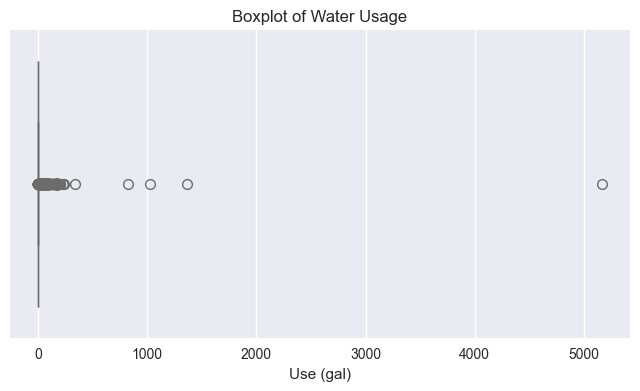

In [490]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df1['Use (gal)'])
plt.title("Boxplot of Water Usage")
plt.xlabel("Use (gal)")
plt.show()

#Outlier Calculation

In [491]:
Q1 = df1['Use (gal)'].quantile(0.25)
Q3 = df1['Use (gal)'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_cleaned = df1[(df1['Use (gal)'] >= lower_bound) & (df1['Use (gal)'] <= upper_bound)]

print(f"Original rows: {len(df1)}, After removing outliers: {len(df_cleaned)},outlier% = {(len(df1)-len(df_cleaned))/len(df1)*100}")
#14% outlier so no dropping of outliers


Original rows: 596178, After removing outliers: 510807,outlier% = 14.319716594708293


In [492]:
print(df1['Use (gal)'].value_counts().sort_index(ascending=False).head(20))

Use (gal)
5164.56     1
1365.77     1
1024.99     1
821.57      1
340.78      1
240.40      1
229.83      1
224.55      1
198.13      4
195.49      1
192.85      1
190.20      2
187.56      1
184.92      3
182.28      5
179.64      7
177.00      4
174.35     14
171.71     29
169.07     31
Name: count, dtype: int64


In [493]:
df1[df1['Use (gal)']>300]

,Building Name,Unit,Meter #,Time Adjusted by Property,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Battery(Volts),Source_File,...,Unit Class,No. Bedrooms,No. Full Baths,No. Half Baths,Stories,Unit Size (Sf),Date,Hour,DayOfWeek,Month
48912,Building 01,1312.0,B83B8FFFFE000B21,2025-01-25 03:00:25,821.57,2821.36,71.1,-40,3.00,2025-01 - Native Data for Models-January(Janua...,...,Flat,2,2,0,1,1165,2025-01-25,3,5,1
72269,Building 01,1507.0,B83B8FFFFE00127D,2025-01-30 15:14:11,1024.99,5500.06,72.8,-54,3.02,2025-01 - Native Data for Models-January(Janua...,...,Flat,1,1,0,1,632,2025-01-30,15,3,1
200311,Building 01,2404.0,B83B8FFFFE0012D5,2025-01-13 08:10:23,1365.77,11858.68,78.4,-129,3.02,2025-01 - Native Data for Models-January(Janua...,...,Flat,2,2,0,1,1204,2025-01-13,8,0,1
532632,Building 01,1802.0,01030000010395F8,2025-04-26 23:02:41,340.78,18204.09,70.5,-95,3.00,2025-04 - Native Data for Models-April(1).csv,...,Flat,3,2,0,1,1375,2025-04-26,23,5,4
565474,Building 01,2410.0,B83B8FFFFE000FA0,2025-04-23 12:52:44,5164.56,9914.38,78.9,-94,3.00,2025-04 - Native Data for Models-April(1).csv,...,Flat,2,2,0,1,1295,2025-04-23,12,2,4


#Dropping Extreme Values and taking values<300 Gal water usage

In [515]:
df1=df1[df1['Use (gal)']<300]

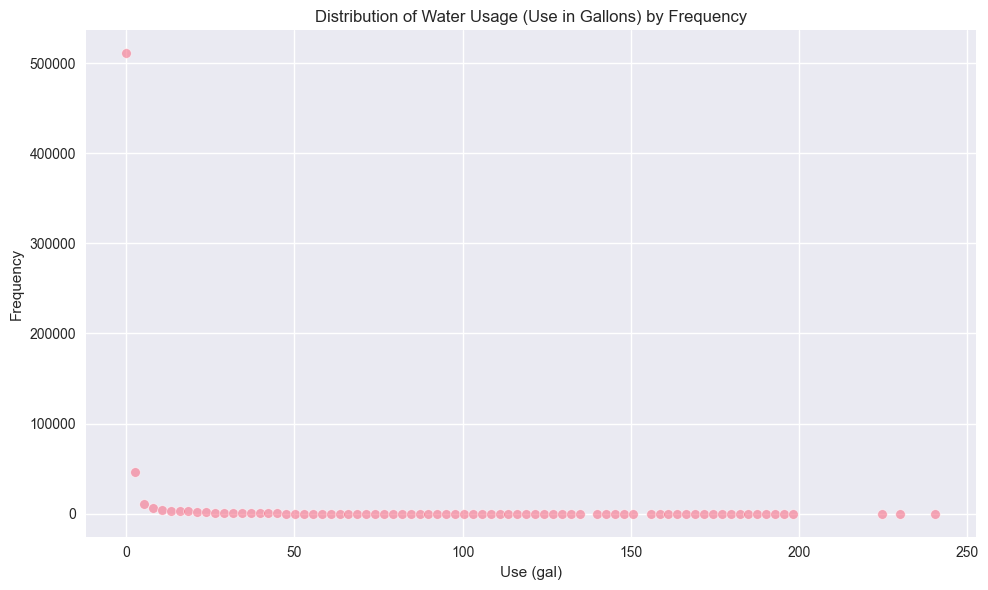

In [495]:
# Step 1: Group by 'Use (gal)' to get frequency
use_freq = df1['Use (gal)'].value_counts().reset_index()
use_freq.columns = ['Use (gal)', 'Frequency']

# Step 2: Sort by Use (gal) for better visual
use_freq = use_freq.sort_values('Use (gal)')

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=use_freq, x='Use (gal)', y='Frequency', alpha=0.6)
plt.title('Distribution of Water Usage (Use in Gallons) by Frequency')
plt.xlabel('Use (gal)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


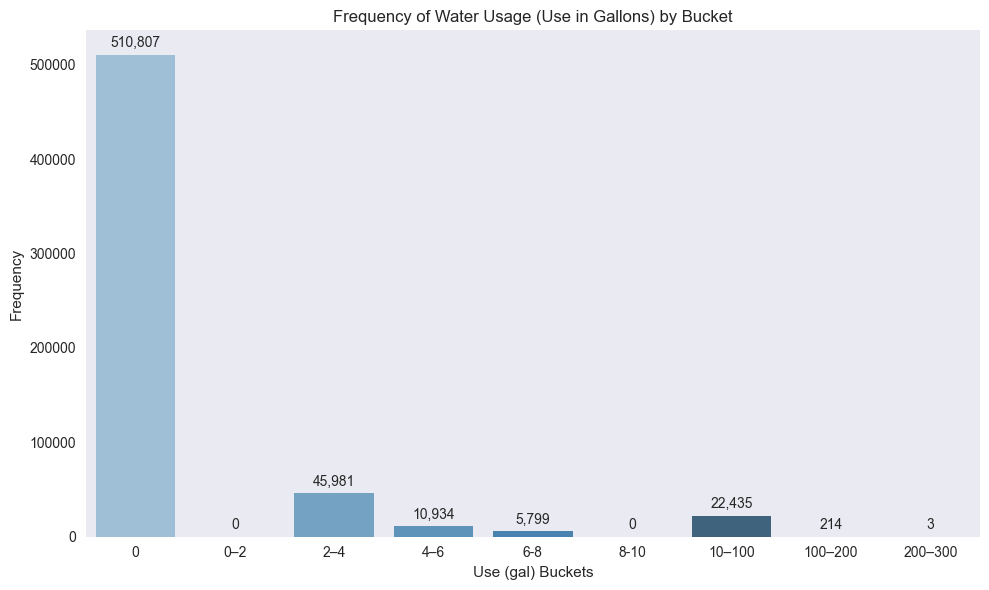

In [518]:
# Define bins and labels
bins = [-0.1, 0, 2, 4, 6, 8,  10, 100, 200, 300]
labels = ['0', '0–2', '2–4','4–6', '6-8','8-10', '10–100', '100–200', '200–300']

# Create bucket column
df1['use_bucket'] = pd.cut(df1['Use (gal)'], bins=bins, labels=labels)

# Count frequency in each bucket
bucket_counts = df1['use_bucket'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette='Blues_d')

# Add count labels on top of each bar
for i, value in enumerate(bucket_counts.values):
    ax.text(i, value + 0.01 * max(bucket_counts.values), f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.title('Frequency of Water Usage (Use in Gallons) by Bucket')
plt.xlabel('Use (gal) Buckets')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [497]:
def plot_bar_with_labels(df, group_col, value_col='Use (gal)', agg='mean', title=None, figsize=(10, 6)):
    """
    Creates a bar plot for the specified grouping column with value labels.

    Parameters:
    - df: DataFrame
    - group_col: Column to group by
    - value_col: Column to aggregate
    - agg: Aggregation method - 'sum' or 'mean' or 'count'
    - title: Optional plot title
    - figsize: Tuple for figure size
    """
    # Aggregate
    if agg == 'sum':
        grouped = df.groupby(group_col)[value_col].sum()
    elif agg == 'mean':
        grouped = df.groupby(group_col)[value_col].mean()
    elif agg == 'count':
        grouped = df[group_col].value_counts()
    else:
        raise ValueError("Aggregation must be 'sum', 'mean', or 'count'")

    grouped = grouped.sort_index()

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=grouped.index.astype(str), y=grouped.values, palette='rocket')
    plt.title(title or f'{agg.capitalize()} of {value_col} by {group_col}')
    plt.xlabel(group_col)
    plt.ylabel(f'{agg.capitalize()} of {value_col}')
    plt.xticks(rotation=45)

    # Add value labels
    for i, v in enumerate(grouped.values):
        ax.text(i, v + 0.01 * max(grouped.values), f'{v:,.0f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

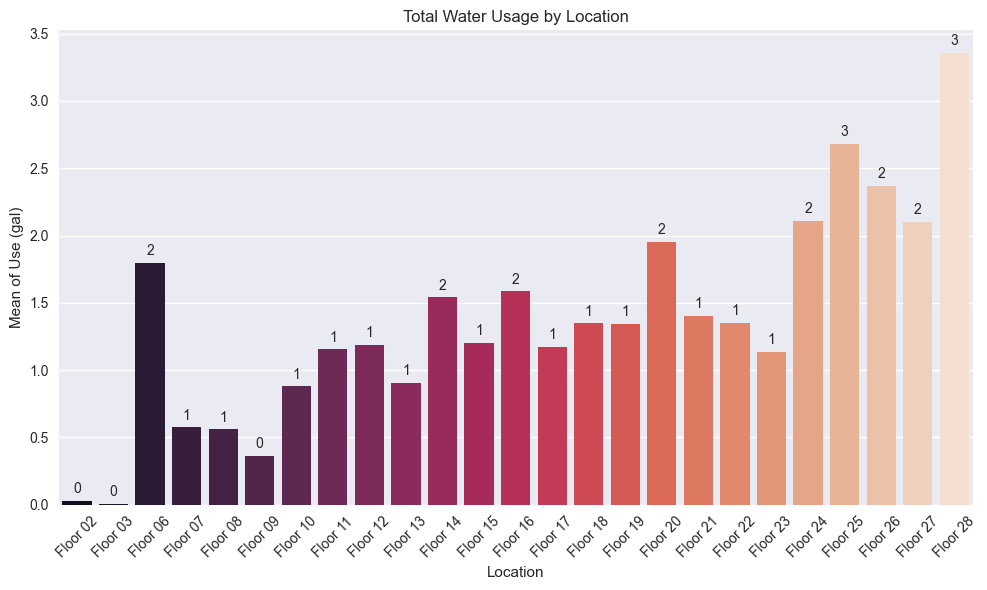

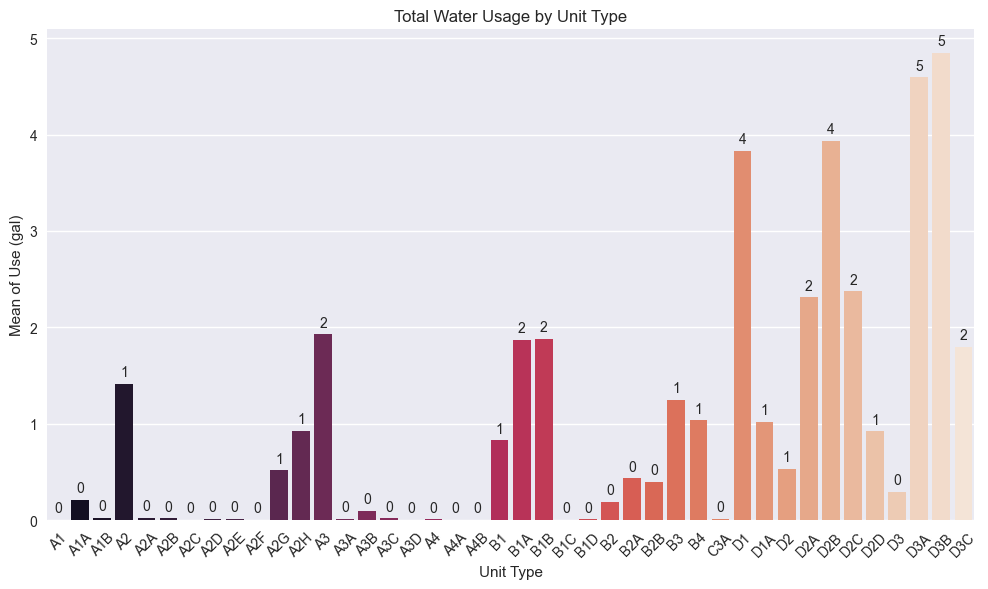

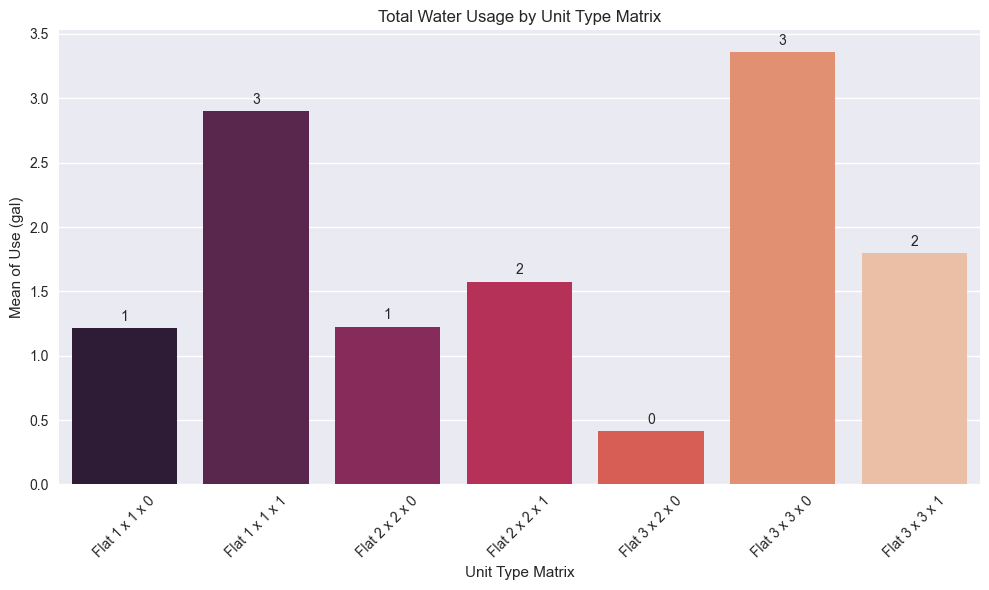

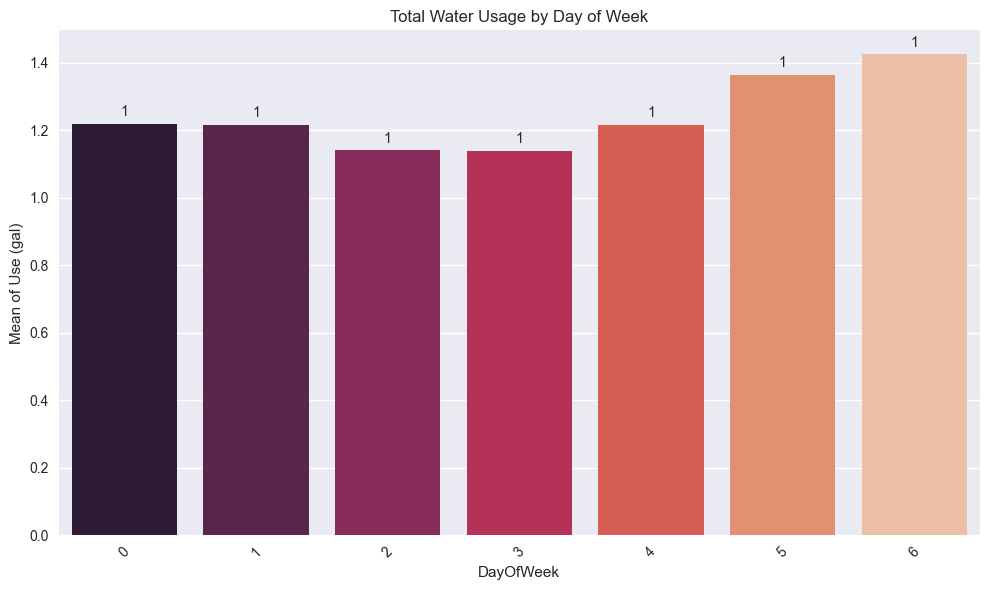

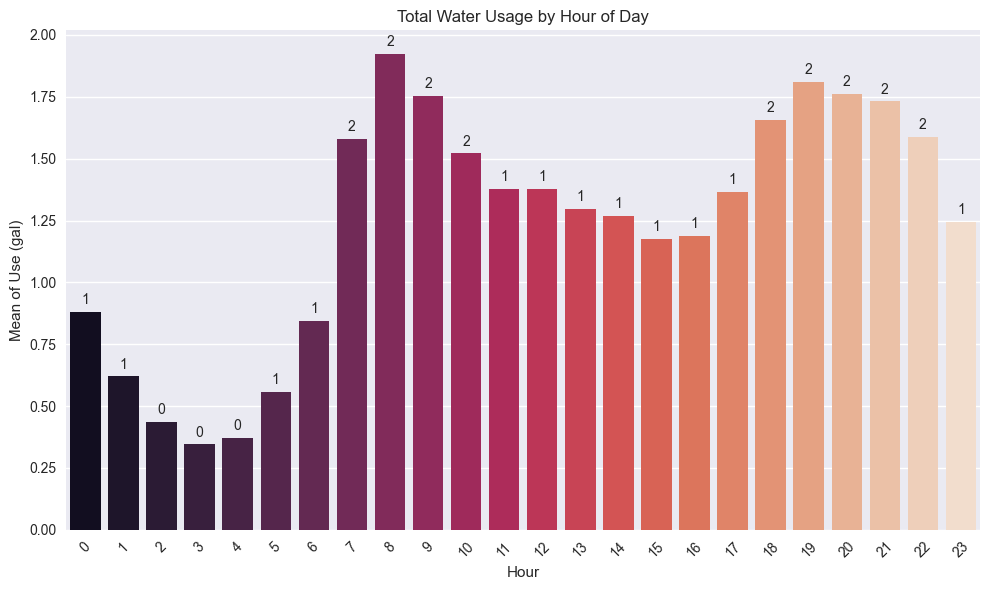

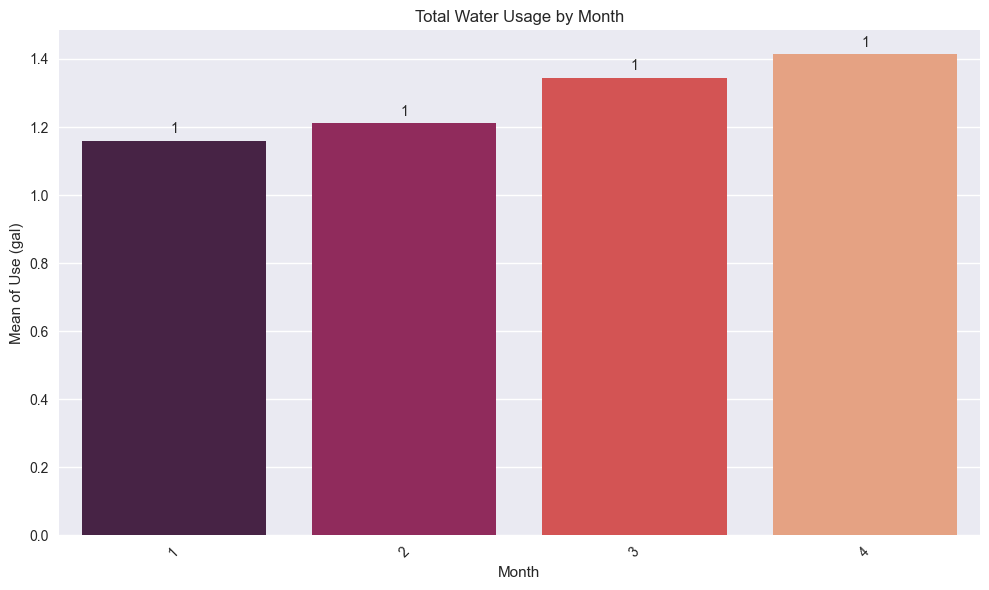

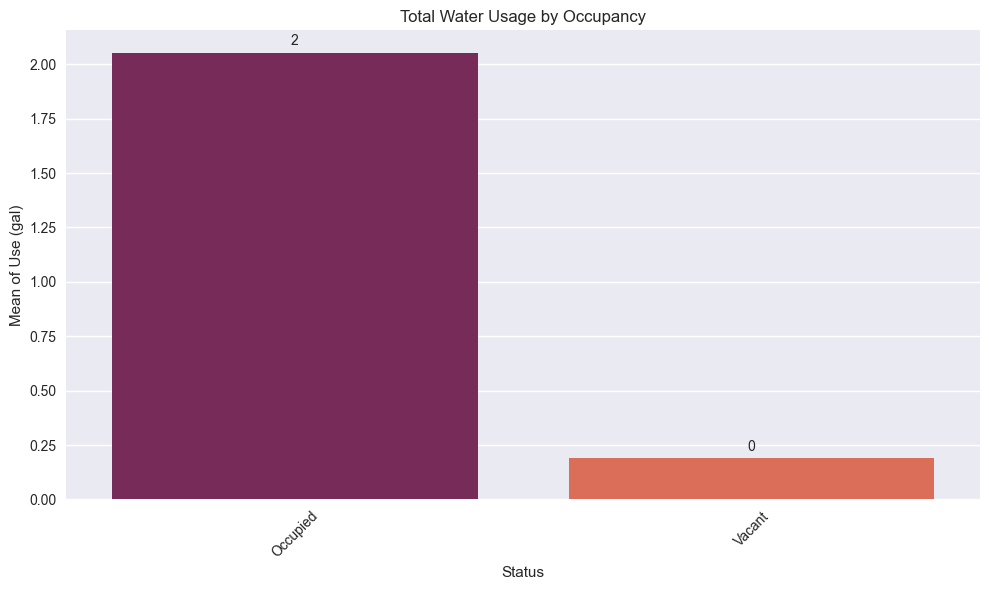

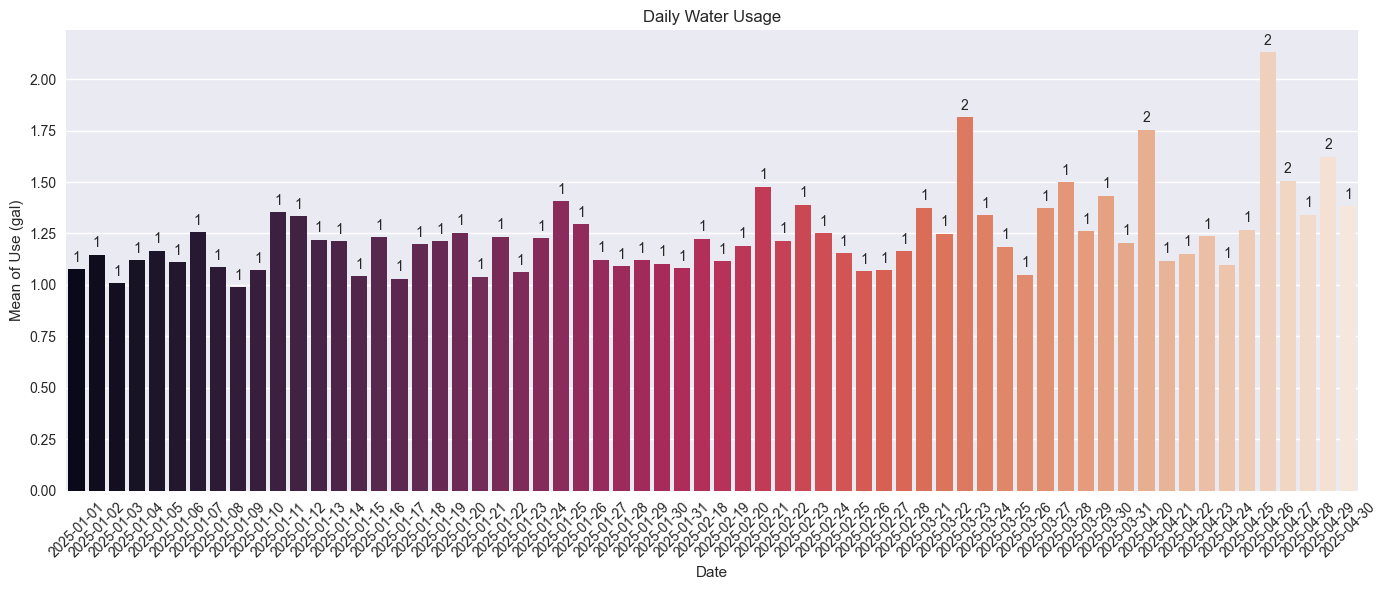

In [519]:
# Water usage by Location
plot_bar_with_labels(df1, 'Location', title='Total Water Usage by Location')

# Water usage by Unit Type
plot_bar_with_labels(df1, 'Unit Type', title='Total Water Usage by Unit Type')

# Water usage by Unit Type Matrix
plot_bar_with_labels(df1, 'Unit Type Matrix', title='Total Water Usage by Unit Type Matrix')

# Water usage by Day of Week
plot_bar_with_labels(df1, 'DayOfWeek', title='Total Water Usage by Day of Week')

# Water usage by Hour
plot_bar_with_labels(df1, 'Hour', title='Total Water Usage by Hour of Day')

# Water usage by Month
plot_bar_with_labels(df1, 'Month', title='Total Water Usage by Month')

plot_bar_with_labels(df1,'Status', title= 'Total Water Usage by Occupancy')

plot_bar_with_labels(df1, 'Date', title='Daily Water Usage', figsize=(14, 6))


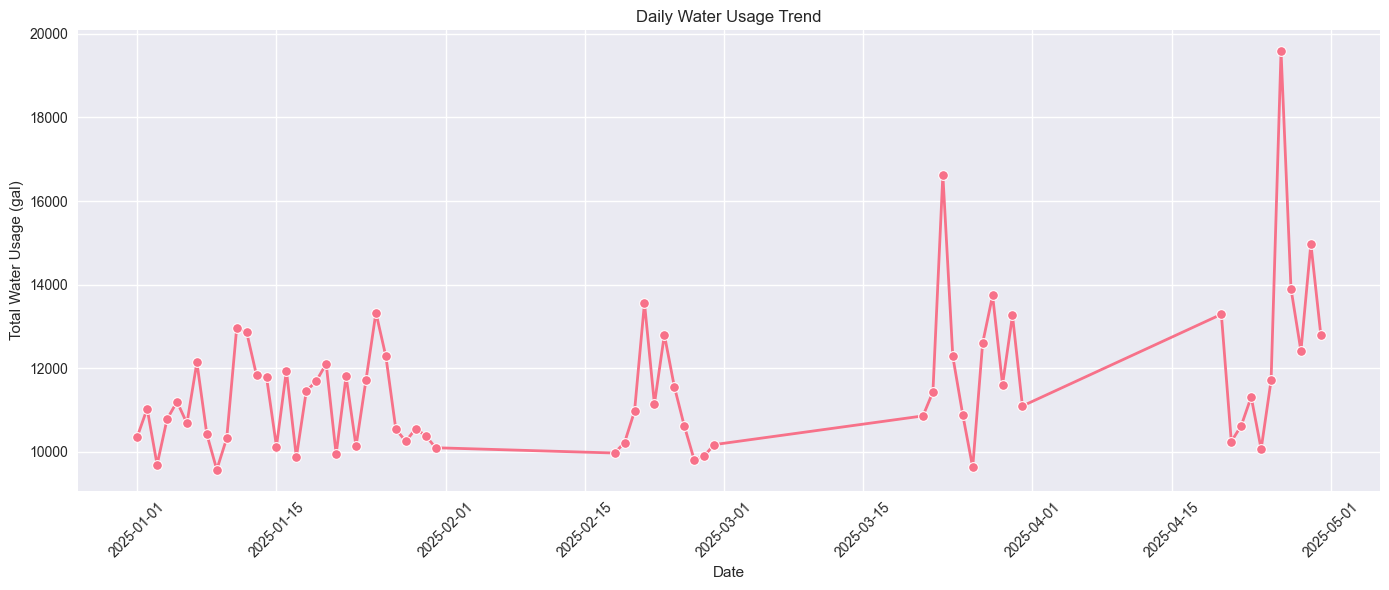

<Axes: xlabel='Signal Strength', ylabel='Use (gal)'>

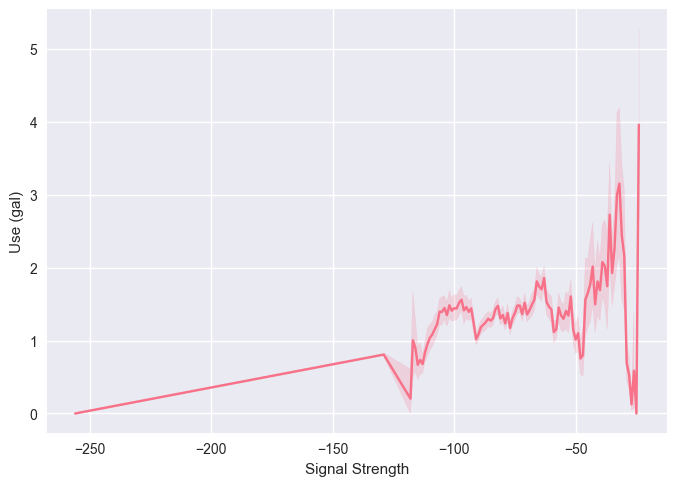

In [499]:
# Group by date to get daily total usage
daily_usage = df1.groupby('Date')['Use (gal)'].sum().reset_index()

# Plot the line chart
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Use (gal)', data=daily_usage, marker='o', linewidth=2)

plt.title('Daily Water Usage Trend')
plt.xlabel('Date')
plt.ylabel('Total Water Usage (gal)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

daily_usage['7d_avg'] = daily_usage['Use (gal)'].rolling(window=7).mean()

#sns.lineplot(x='Date', y='7d_avg', data=daily_usage, label='7-Day Avg', linestyle='--', color='orange')


sns.lineplot(x='Signal Strength', y= 'Use (gal)', data = df1)

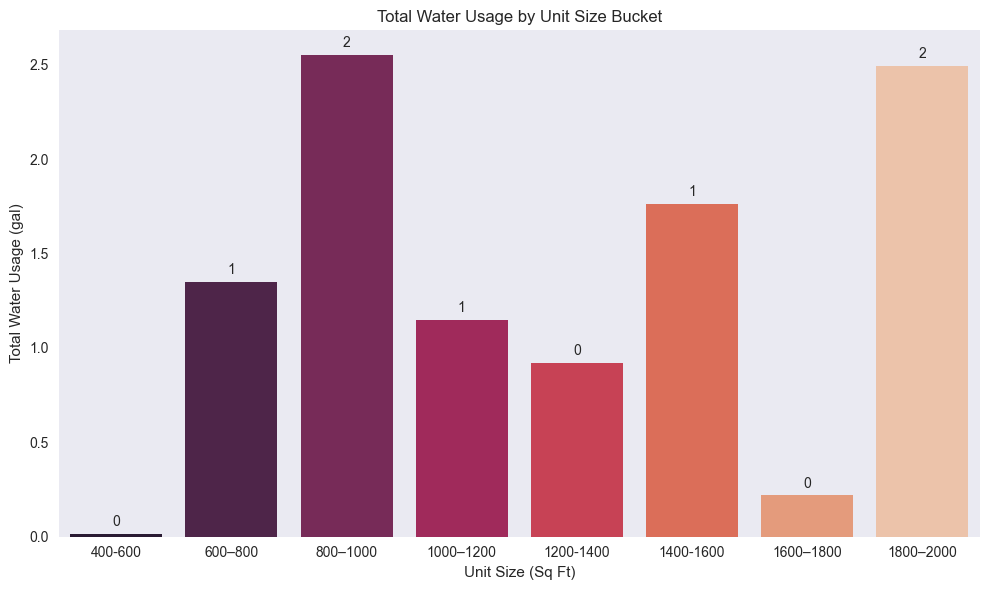

In [520]:
# Define bins and labels
bins = [400, 600, 800, 1000, 1200, 1400,  1600, 1800, 2000]
labels = ['400-600', '600–800', '800–1000','1000–1200', '1200-1400','1400-1600', '1600–1800', '1800–2000']

# Create bucket column
df1['unit_bucket'] = pd.cut(df1['Unit Size (Sf)'], bins=bins, labels=labels)

bucket_usage = df1.groupby('unit_bucket')['Use (gal)'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='unit_bucket', y='Use (gal)', data=bucket_usage, palette='rocket')

# Add labels on top of bars
for i, value in enumerate(bucket_usage['Use (gal)']):
    ax.text(i, value + 0.01 * bucket_usage['Use (gal)'].max(), f'{int(value):,}',
            ha='center', va='bottom', fontsize=10)

plt.title('Total Water Usage by Unit Size Bucket')
plt.xlabel('Unit Size (Sq Ft)')
plt.ylabel('Total Water Usage (gal)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

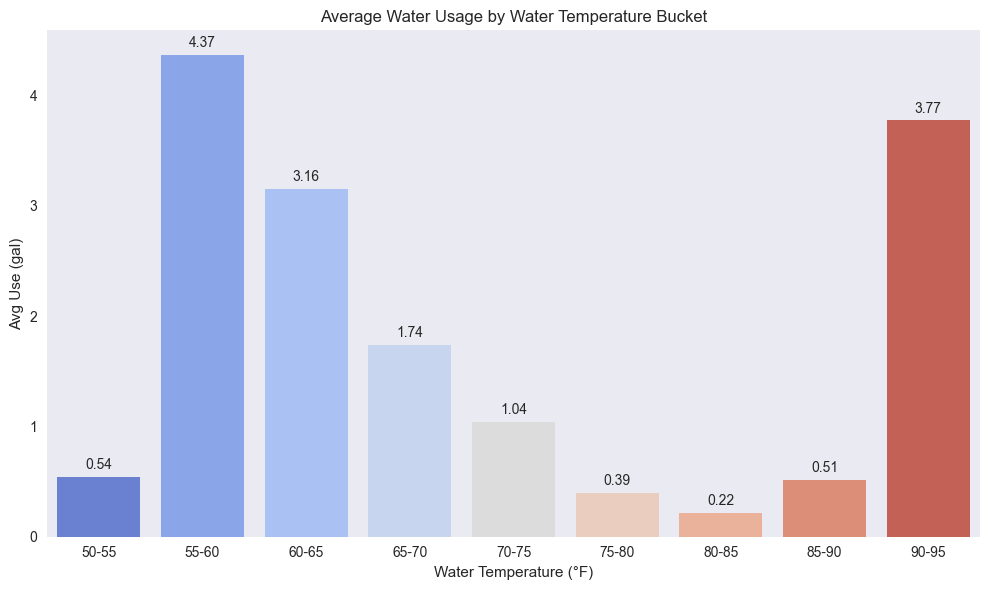

In [521]:
# Define bins and labels for Water Temp
bins = list(range(50, 100, 5))  # e.g., [50, 55, 60, ..., 90]
labels = [f'{i}-{i+5}' for i in bins[:-1]]

# Create temperature bucket column
df1['temp_bucket'] = pd.cut(df1['Water Temp (gal)'], bins=bins, labels=labels)

# Group by temperature bucket and calculate average water usage
temp_usage = df1.groupby('temp_bucket')['Use (gal)'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='temp_bucket', y='Use (gal)', data=temp_usage, palette='coolwarm')

# Add value labels on top of bars
for i, value in enumerate(temp_usage['Use (gal)']):
    ax.text(i, value + 0.01 * temp_usage['Use (gal)'].max(), f'{value:.2f}',
            ha='center', va='bottom', fontsize=10)

plt.title('Average Water Usage by Water Temperature Bucket')
plt.xlabel('Water Temperature (°F)')
plt.ylabel('Avg Use (gal)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

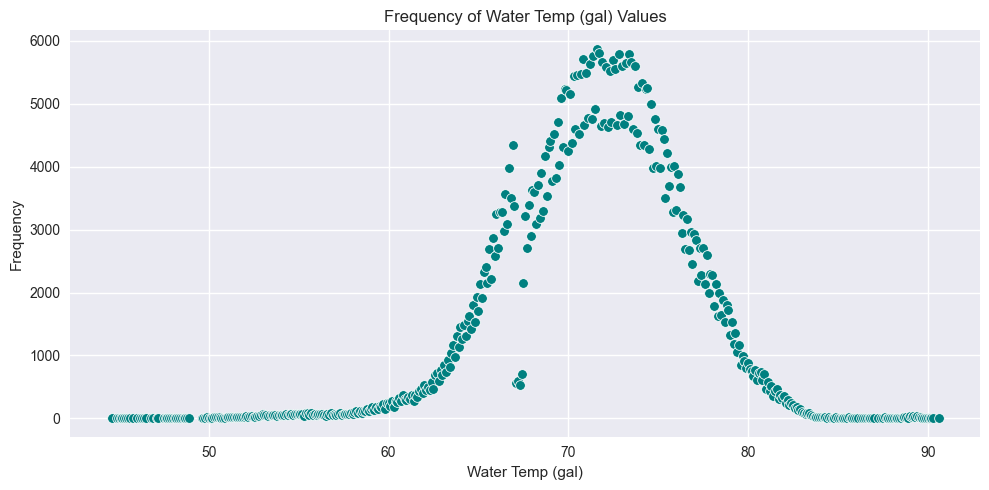

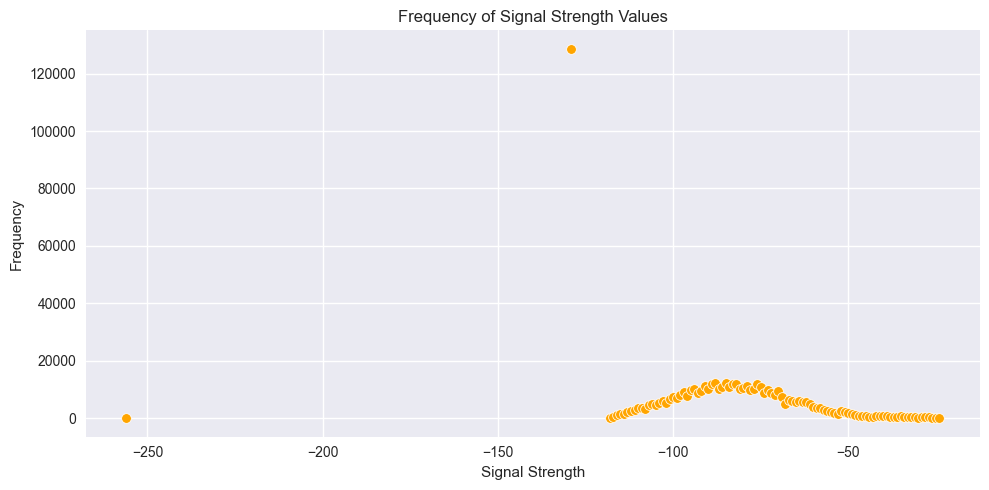

In [522]:
def plot_frequency_scatter(df, column, color='teal', figsize=(10, 5)):
    """
    Plots a scatter plot of unique values in a column vs their frequency.

    Parameters:
    - df: DataFrame
    - column: Column name (str) to analyze
    - color: Scatter color
    - figsize: Size of the plot
    """
    # Count frequency of each unique value
    freq_df = df[column].value_counts().reset_index()
    freq_df.columns = [column, 'Frequency']
    freq_df = freq_df.sort_values(column)

    # Plot
    plt.figure(figsize=figsize)
    sns.scatterplot(data=freq_df, x=column, y='Frequency', color=color)
    plt.title(f'Frequency of {column} Values')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Water Temp vs Frequency
plot_frequency_scatter(df1, 'Water Temp (gal)', color='teal')

# Signal Strength vs Frequency
plot_frequency_scatter(df1, 'Signal Strength', color='orange')



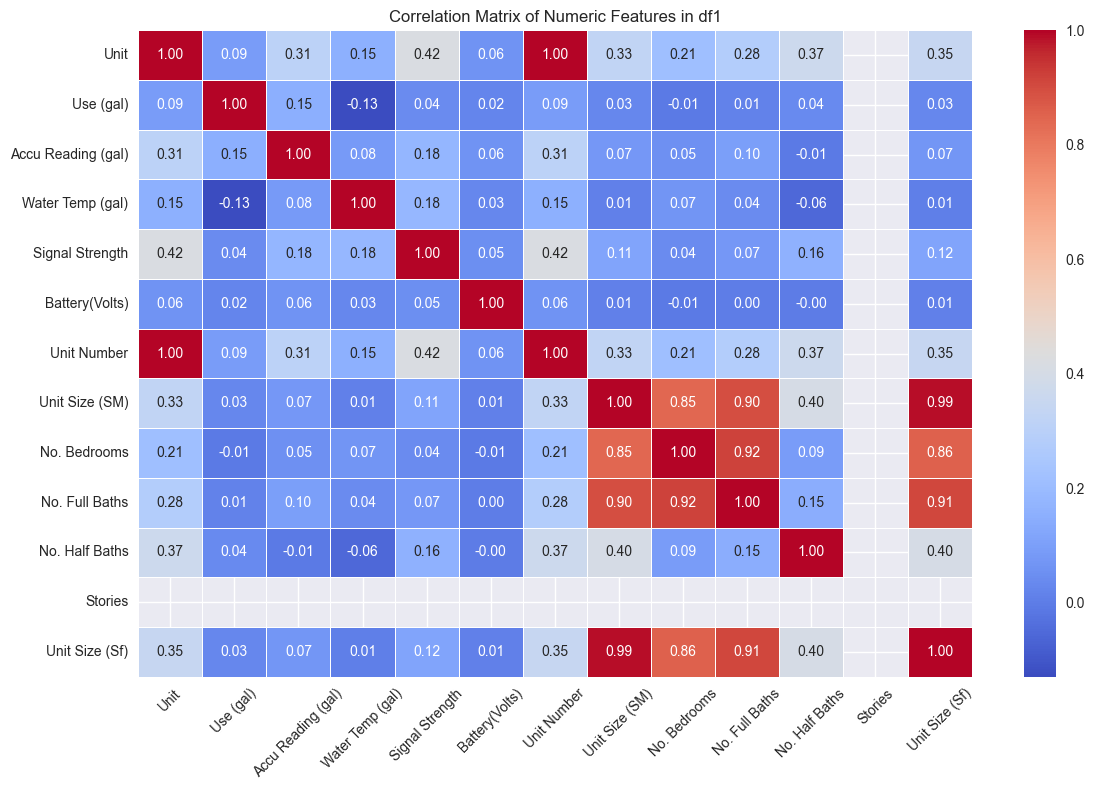

In [504]:
# Step 1: Select only numeric columns
numeric_df = df1.select_dtypes(include=['float64', 'int64'])

# Step 2: Compute correlation matrix
corr_matrix = numeric_df.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Numeric Features in df1")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [523]:
df1['Status'].value_counts()

Status
Occupied    336504
Vacant      259669
Name: count, dtype: Int64

In [524]:
df1.columns

Index(['Building Name', 'Unit', 'Meter #', 'Time Adjusted by Property',
       'Use (gal)', 'Accu Reading (gal)', 'Water Temp (gal)',
       'Signal Strength', 'Battery(Volts)', 'Source_File', 'Location',
       'Unit Number', 'Unit Type', 'Status', 'Unit Size (SM)',
       'Unit Type Matrix', 'Unit Class', 'No. Bedrooms', 'No. Full Baths',
       'No. Half Baths', 'Stories', 'Unit Size (Sf)', 'Date', 'Hour',
       'DayOfWeek', 'Month', 'use_bucket', 'unit_bucket', 'temp_bucket'],
      dtype='object')

In [525]:
df1.drop(columns = ['Meter #', 'Battery(Volts)', 'Source_File', 'Stories', 'Unit Class', 'Building Name','use_bucket','unit_bucket','temp_bucket','Unit Type Matrix'], inplace=True)

In [526]:
df1.columns

Index(['Unit', 'Time Adjusted by Property', 'Use (gal)', 'Accu Reading (gal)',
       'Water Temp (gal)', 'Signal Strength', 'Location', 'Unit Number',
       'Unit Type', 'Status', 'Unit Size (SM)', 'No. Bedrooms',
       'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'Date', 'Hour',
       'DayOfWeek', 'Month'],
      dtype='object')

In [527]:
df1['Unit'] = df1['Unit'].astype('Int64')
df_sorted = df1.sort_values(by=['Unit', 'Time Adjusted by Property'], ascending=[True, True])
df_sorted.reset_index(inplace=True)
df_sorted.drop(columns=['index'], inplace=True)

In [528]:
df_sorted

,Unit,Time Adjusted by Property,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Location,Unit Number,Unit Type,Status,Unit Size (SM),No. Bedrooms,No. Full Baths,No. Half Baths,Unit Size (Sf),Date,Hour,DayOfWeek,Month
0,202,2025-01-01 00:27:40,0.0,538.91,66.0,-90,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,0,2,1
1,202,2025-01-01 01:27:45,0.0,538.91,66.0,-94,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,1,2,1
2,202,2025-01-01 01:27:49,0.0,538.91,66.0,-94,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,1,2,1
3,202,2025-01-01 02:27:50,0.0,538.91,65.9,-94,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,2,2,1
4,202,2025-01-01 03:27:54,0.0,538.91,65.8,-87,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596168,2806,2025-04-30 19:41:16,0.0,1299.73,78.8,-103,Floor 28,2806.0,D2,Vacant,0.00,2,2,0,1204,2025-04-30,19,2,4
596169,2806,2025-04-30 20:41:20,0.0,1299.73,78.8,-104,Floor 28,2806.0,D2,Vacant,0.00,2,2,0,1204,2025-04-30,20,2,4
596170,2806,2025-04-30 21:41:25,0.0,1299.73,78.8,-105,Floor 28,2806.0,D2,Vacant,0.00,2,2,0,1204,2025-04-30,21,2,4
596171,2806,2025-04-30 22:41:30,0.0,1299.73,78.8,-105,Floor 28,2806.0,D2,Vacant,0.00,2,2,0,1204,2025-04-30,22,2,4


In [529]:
df1.dtypes

Unit                                  Int64
Time Adjusted by Property    datetime64[ns]
Use (gal)                           float64
Accu Reading (gal)                  float64
Water Temp (gal)                    float64
Signal Strength                       Int64
Location                     string[python]
Unit Number                         float64
Unit Type                    string[python]
Status                       string[python]
Unit Size (SM)                      float64
No. Bedrooms                          Int64
No. Full Baths                        Int64
No. Half Baths                        Int64
Unit Size (Sf)                        Int64
Date                                 object
Hour                                  int32
DayOfWeek                             int32
Month                                 int32
dtype: object

# Clean Data saved

In [530]:
df_sorted.to_csv('clean_data.csv', index=False)

In [531]:

df_sorted = pd.read_csv('clean_data.csv')
df_sorted

,Unit,Time Adjusted by Property,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Location,Unit Number,Unit Type,Status,Unit Size (SM),No. Bedrooms,No. Full Baths,No. Half Baths,Unit Size (Sf),Date,Hour,DayOfWeek,Month
0,202,2025-01-01 00:27:40,0.0,538.91,66.0,-90,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,0,2,1
1,202,2025-01-01 01:27:45,0.0,538.91,66.0,-94,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,1,2,1
2,202,2025-01-01 01:27:49,0.0,538.91,66.0,-94,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,1,2,1
3,202,2025-01-01 02:27:50,0.0,538.91,65.9,-94,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,2,2,1
4,202,2025-01-01 03:27:54,0.0,538.91,65.8,-87,Floor 02,202.0,C3A,Vacant,110.65,2,2,0,1191,2025-01-01,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596168,2806,2025-04-30 19:41:16,0.0,1299.73,78.8,-103,Floor 28,2806.0,D2,Vacant,0.00,2,2,0,1204,2025-04-30,19,2,4
596169,2806,2025-04-30 20:41:20,0.0,1299.73,78.8,-104,Floor 28,2806.0,D2,Vacant,0.00,2,2,0,1204,2025-04-30,20,2,4
596170,2806,2025-04-30 21:41:25,0.0,1299.73,78.8,-105,Floor 28,2806.0,D2,Vacant,0.00,2,2,0,1204,2025-04-30,21,2,4
596171,2806,2025-04-30 22:41:30,0.0,1299.73,78.8,-105,Floor 28,2806.0,D2,Vacant,0.00,2,2,0,1204,2025-04-30,22,2,4


In [532]:
df_new = df_sorted.copy()
df_new['Time Adjusted by Property']=pd.to_datetime(df_new['Time Adjusted by Property'])
df_new['hourly_time'] = df_new['Time Adjusted by Property'].dt.floor('H')
df_new = df_new.set_index('Time Adjusted by Property')
# Group by hour and key identifiers
df_new = df_new.groupby([
    pd.Grouper(freq='H'),  # Groups by each hour
    'Unit'
]).agg({
    'Use (gal)': 'sum',
    'Accu Reading (gal)': 'mean',
    'Water Temp (gal)': 'mean',
    'Signal Strength': 'mean',
    'Location': 'first',
    'Unit Number': 'first',
    'Unit Type': 'first',
    'Status': 'first',
    'Unit Size (SM)': 'first',
    
    'No. Bedrooms': 'first',
    'No. Full Baths': 'first',
    'No. Half Baths': 'first',
    'Unit Size (Sf)': 'first',
    'Date': 'first',
    'Hour': 'first',
    'DayOfWeek': 'first',
    'Month': 'first'
}).reset_index()

In [533]:
df_new = df_new.sort_values(by=['Unit', 'Date', 'Hour'], ascending=[True, True, True])
df_new.reset_index(inplace=True)
df_new.drop(columns=['index'], inplace=True)


In [373]:
df_new

,Time Adjusted by Property,Unit,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Location,Unit Number,Unit Type,Status,Unit Size (SM),Unit Type Matrix,No. Bedrooms,No. Full Baths,No. Half Baths,Unit Size (Sf),Date,Hour,DayOfWeek,Month
0,2025-01-01 00:00:00,202,0.0,538.91,66.0,-90.0,Floor 02,202.0,C3A,Vacant,110.65,Flat 2 x 2 x 0,2,2,0,1191,2025-01-01,0,2,1
1,2025-01-01 01:00:00,202,0.0,538.91,66.0,-94.0,Floor 02,202.0,C3A,Vacant,110.65,Flat 2 x 2 x 0,2,2,0,1191,2025-01-01,1,2,1
2,2025-01-01 02:00:00,202,0.0,538.91,65.9,-94.0,Floor 02,202.0,C3A,Vacant,110.65,Flat 2 x 2 x 0,2,2,0,1191,2025-01-01,2,2,1
3,2025-01-01 03:00:00,202,0.0,538.91,65.8,-87.0,Floor 02,202.0,C3A,Vacant,110.65,Flat 2 x 2 x 0,2,2,0,1191,2025-01-01,3,2,1
4,2025-01-01 04:00:00,202,0.0,538.91,65.7,-90.0,Floor 02,202.0,C3A,Vacant,110.65,Flat 2 x 2 x 0,2,2,0,1191,2025-01-01,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586734,2025-04-30 19:00:00,2806,0.0,1299.73,78.8,-103.0,Floor 28,2806.0,D2,Vacant,0.00,Flat 2 x 2 x 0,2,2,0,1204,2025-04-30,19,2,4
586735,2025-04-30 20:00:00,2806,0.0,1299.73,78.8,-104.0,Floor 28,2806.0,D2,Vacant,0.00,Flat 2 x 2 x 0,2,2,0,1204,2025-04-30,20,2,4
586736,2025-04-30 21:00:00,2806,0.0,1299.73,78.8,-105.0,Floor 28,2806.0,D2,Vacant,0.00,Flat 2 x 2 x 0,2,2,0,1204,2025-04-30,21,2,4
586737,2025-04-30 22:00:00,2806,0.0,1299.73,78.8,-105.0,Floor 28,2806.0,D2,Vacant,0.00,Flat 2 x 2 x 0,2,2,0,1204,2025-04-30,22,2,4


In [534]:
# Function to find missing hours per group
def find_missing_hours(group):
    expected_hours = set(range(24))
    present_hours = set(group['Hour'])
    return sorted(expected_hours - present_hours)

# Group by Date and Unit and find missing hours
missing_detail = df_new.groupby(['Date', 'Unit']).apply(find_missing_hours).reset_index(name='Missing Hours')

# Filter only those with missing hours
missing_detail = missing_detail[missing_detail['Missing Hours'].apply(len) > 0]

print(missing_detail)

             Date  Unit Missing Hours
4      2025-01-01   207          [19]
8      2025-01-01   211           [2]
9      2025-01-01   212           [9]
20     2025-01-01   308          [20]
53     2025-01-01   708          [16]
...           ...   ...           ...
24731  2025-04-30  2210           [5]
24740  2025-04-30  2301       [7, 18]
24743  2025-04-30  2304          [17]
24755  2025-04-30  2318          [19]
24777  2025-04-30  2609          [20]

[3357 rows x 3 columns]


## Adding missing hours

In [535]:
all_hours = np.arange(24)
all_dates = df_new['Date'].unique()
all_units = df_new['Unit'].unique()

In [536]:
full_index = pd.DataFrame(
    list(product(all_dates, all_units, all_hours)),
    columns=['Date', 'Unit', 'Hour']
)
df_full = pd.merge(full_index, df_new, on=['Date', 'Unit', 'Hour'], how='left')
df_full = df_full.sort_values(by=['Date', 'Unit', 'Hour']).reset_index(drop=True)

In [537]:
df_full

,Date,Unit,Hour,Time Adjusted by Property,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Location,Unit Number,Unit Type,Status,Unit Size (SM),No. Bedrooms,No. Full Baths,No. Half Baths,Unit Size (Sf),DayOfWeek,Month
0,2025-01-01,202,0,2025-01-01 00:00:00,0.0,538.91,66.0,-90.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
1,2025-01-01,202,1,2025-01-01 01:00:00,0.0,538.91,66.0,-94.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
2,2025-01-01,202,2,2025-01-01 02:00:00,0.0,538.91,65.9,-94.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
3,2025-01-01,202,3,2025-01-01 03:00:00,0.0,538.91,65.8,-87.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
4,2025-01-01,202,4,2025-01-01 04:00:00,0.0,538.91,65.7,-90.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615931,2025-04-30,2806,19,2025-04-30 19:00:00,0.0,1299.73,78.8,-103.0,Floor 28,2806.0,D2,Vacant,0.00,2.0,2.0,0.0,1204.0,2.0,4.0
615932,2025-04-30,2806,20,2025-04-30 20:00:00,0.0,1299.73,78.8,-104.0,Floor 28,2806.0,D2,Vacant,0.00,2.0,2.0,0.0,1204.0,2.0,4.0
615933,2025-04-30,2806,21,2025-04-30 21:00:00,0.0,1299.73,78.8,-105.0,Floor 28,2806.0,D2,Vacant,0.00,2.0,2.0,0.0,1204.0,2.0,4.0
615934,2025-04-30,2806,22,2025-04-30 22:00:00,0.0,1299.73,78.8,-105.0,Floor 28,2806.0,D2,Vacant,0.00,2.0,2.0,0.0,1204.0,2.0,4.0


In [538]:
df_full.isna().sum()

Date                             0
Unit                             0
Hour                             0
Time Adjusted by Property    29197
Use (gal)                    29197
Accu Reading (gal)           29197
Water Temp (gal)             29197
Signal Strength              29197
Location                     29197
Unit Number                  29197
Unit Type                    29197
Status                       29197
Unit Size (SM)               29197
No. Bedrooms                 29197
No. Full Baths               29197
No. Half Baths               29197
Unit Size (Sf)               29197
DayOfWeek                    29197
Month                        29197
dtype: int64

In [539]:
# Fill Accu Reading (gal)
# Interpolate Accumulated Reading using time-based interpolation

df_full['Accu Reading (gal)'] = df_full['Accu Reading (gal)'].interpolate(method='linear')


# Fill Use (gal) by calculating actual hourly usage from Accumulated Reading

# Step 1: Calculate usage based on accumulated readings
calculated_use = df_full.groupby('Unit')['Accu Reading (gal)'].diff()

# Step 2: Replace NaN diffs (usually the first record per group) with 0
calculated_use = calculated_use.fillna(0)

# Step 3: Set negative usage to 0 (usage can't be negative)
calculated_use = calculated_use.clip(lower=0)

# Step 4: Cap outliers to 99.5th percentile of existing 'Use (gal)' values
upper_limit = df_full['Use (gal)'].quantile(0.995)
calculated_use = calculated_use.clip(upper=upper_limit)

# Step 5: Fill missing 'Use (gal)' values ONLY
mask_missing = df_full['Use (gal)'].isna()
df_full.loc[mask_missing, 'Use (gal)'] = calculated_use.loc[mask_missing]

In [540]:
# Fill Water Temp (gal)
# Interpolated - as they vary smoothly

mask_missing = df_full['Water Temp (gal)'].isna()

# Calculate interpolated values within each Unit
interp_values = (
    df_full.groupby('Unit')['Water Temp (gal)']
    .transform(lambda x: x.interpolate(method='linear').ffill().bfill())
)

# Fill only missing values
df_full.loc[mask_missing, 'Water Temp (gal)'] = interp_values.loc[mask_missing]

In [541]:
# Constant for other missing columns values

meta_cols = ['Location','Signal Strength', 'Unit Type', 'Status', 'Unit Size (SM)', 
             'No. Bedrooms', 'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'Unit Number', 'DayOfWeek', 'Month']

mask_missing = df_full[meta_cols].isna()

# Compute forward/backward fill per group
filled = df_full.groupby('Unit')[meta_cols].ffill().bfill()

# Only fill missing values per column
for col in meta_cols:
    df_full.loc[mask_missing[col], col] = filled.loc[mask_missing[col], col]

In [542]:
df_full.isna().sum()

Date                             0
Unit                             0
Hour                             0
Time Adjusted by Property    29197
Use (gal)                        0
Accu Reading (gal)               0
Water Temp (gal)                 0
Signal Strength                  0
Location                         0
Unit Number                      0
Unit Type                        0
Status                           0
Unit Size (SM)                   0
No. Bedrooms                     0
No. Full Baths                   0
No. Half Baths                   0
Unit Size (Sf)                   0
DayOfWeek                        0
Month                            0
dtype: int64

In [543]:
# Recreated 'Time Adjusted by Property' to handle missing values in time column

df_full['Time Adjusted by Property'] = pd.to_datetime(df_full['Date']) + pd.to_timedelta(df_full['Hour'], unit='h')

In [544]:
df_full.isna().sum()

Date                         0
Unit                         0
Hour                         0
Time Adjusted by Property    0
Use (gal)                    0
Accu Reading (gal)           0
Water Temp (gal)             0
Signal Strength              0
Location                     0
Unit Number                  0
Unit Type                    0
Status                       0
Unit Size (SM)               0
No. Bedrooms                 0
No. Full Baths               0
No. Half Baths               0
Unit Size (Sf)               0
DayOfWeek                    0
Month                        0
dtype: int64

In [545]:
df_full

,Date,Unit,Hour,Time Adjusted by Property,Use (gal),Accu Reading (gal),Water Temp (gal),Signal Strength,Location,Unit Number,Unit Type,Status,Unit Size (SM),No. Bedrooms,No. Full Baths,No. Half Baths,Unit Size (Sf),DayOfWeek,Month
0,2025-01-01,202,0,2025-01-01 00:00:00,0.0,538.91,66.0,-90.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
1,2025-01-01,202,1,2025-01-01 01:00:00,0.0,538.91,66.0,-94.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
2,2025-01-01,202,2,2025-01-01 02:00:00,0.0,538.91,65.9,-94.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
3,2025-01-01,202,3,2025-01-01 03:00:00,0.0,538.91,65.8,-87.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
4,2025-01-01,202,4,2025-01-01 04:00:00,0.0,538.91,65.7,-90.0,Floor 02,202.0,C3A,Vacant,110.65,2.0,2.0,0.0,1191.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615931,2025-04-30,2806,19,2025-04-30 19:00:00,0.0,1299.73,78.8,-103.0,Floor 28,2806.0,D2,Vacant,0.00,2.0,2.0,0.0,1204.0,2.0,4.0
615932,2025-04-30,2806,20,2025-04-30 20:00:00,0.0,1299.73,78.8,-104.0,Floor 28,2806.0,D2,Vacant,0.00,2.0,2.0,0.0,1204.0,2.0,4.0
615933,2025-04-30,2806,21,2025-04-30 21:00:00,0.0,1299.73,78.8,-105.0,Floor 28,2806.0,D2,Vacant,0.00,2.0,2.0,0.0,1204.0,2.0,4.0
615934,2025-04-30,2806,22,2025-04-30 22:00:00,0.0,1299.73,78.8,-105.0,Floor 28,2806.0,D2,Vacant,0.00,2.0,2.0,0.0,1204.0,2.0,4.0


In [546]:
duplicate_count = df_full.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 0


# Feature Engineering

In [547]:
# df_full['floor'] = df_full['Location'].str.extract(r'Floor (\d+)', expand=False).astype(float)
df_full['Location'].unique()

array(['Floor 02', 'Floor 03', 'Floor 06', 'Floor 07', 'Floor 08',
       'Floor 09', 'Floor 10', 'Floor 11', 'Floor 12', 'Floor 13',
       'Floor 14', 'Floor 15', 'Floor 16', 'Floor 17', 'Floor 18',
       'Floor 19', 'Floor 20', 'Floor 21', 'Floor 22', 'Floor 23',
       'Floor 24', 'Floor 25', 'Floor 26', 'Floor 27', 'Floor 28'],
      dtype=object)

In [548]:
df_f=df_full
#df_full=df_f

In [549]:
#df_full['water_use_ema_2h'] = df_full['Use (gal)'].ewm(span=2, adjust=False).mean()
df_full['water_use_ema_3h'] = df_full['Use (gal)'].ewm(span=3, adjust=False).mean()
df_full['water_use_ema_5h'] = df_full['Use (gal)'].ewm(span=5, adjust=False).mean()
#df_full['use_lag_1h'] = df_full['Use (gal)'].shift(1).fillna(0)
df_full['use_lag_24h'] = df_full['Use (gal)'].shift(24).fillna(0)  # same hour yesterday

# df_full['rolling_mean_6h'] = df_full['Use (gal)'].rolling(6).mean()
# df_full['rolling_std_6h'] = df_full['Use (gal)'].rolling(6).std()
# df_full['rolling_mean_24h'] = df_full['Use (gal)'].rolling(24).mean()
# df_full['rolling_std_24h'] = df_full['Use (gal)'].rolling(24).std()
# df_full['rolling_168h_mean'] = df_full.groupby('Unit')['Use (gal)'].transform(lambda x: x.rolling(168, min_periods=24).mean())



In [390]:
#df_full['use_per_sf'] = df_full['Use (gal)'] / (df_full['Unit Size (Sf)']+ 1e-5)


In [550]:
df_full['zero_usage_streak'] = (
    df_full['Use (gal)'].eq(0)
    .groupby((df_full['Use (gal)'] != 0).cumsum()).cumsum()
)

In [551]:
#df_full['spike_ratio'] = df_full['Use (gal)'] / (df_full['rolling_mean_24h'] + 1e-5)
df_full['temp_delta_1h'] = df_full.groupby('Unit')['Water Temp (gal)'].diff()


In [552]:
#df_full['spike_flag'] = ((df_full['Use (gal)'] > (df_full['rolling_mean_24h'] + 2 * df_full['rolling_std_24h']))).astype(int)

# --- Inactivity flag: if last 3 hours were all zero ---
#Taking rolling sum
#df_full['last_2h_sum'] = df_full.groupby('Unit')['Use (gal)'].transform(lambda x: x.rolling(2, min_periods=2).sum())
df_full['last_3h_sum'] = df_full.groupby('Unit')['Use (gal)'].transform(lambda x: x.rolling(3, min_periods=3).sum())
df_full['inactivity_flag'] = (df_full['last_3h_sum'] == 0).astype(int)


In [553]:
df_full['is_weekend'] = df_full['DayOfWeek'].isin([5, 6]).astype(int)
df_full['is_working_hour'] = df_full['Hour'].between(9, 17).astype(int)

df_full['is_night'] = df_full['Hour'].isin(range(0, 6)).astype(int)
df_full['is_morning'] = df_full['Hour'].isin(range(6, 10)).astype(int)
df_full['is_evening'] = df_full['Hour'].isin(range(17, 22)).astype(int)


In [554]:
df_full.columns

Index(['Date', 'Unit', 'Hour', 'Time Adjusted by Property', 'Use (gal)',
       'Accu Reading (gal)', 'Water Temp (gal)', 'Signal Strength', 'Location',
       'Unit Number', 'Unit Type', 'Status', 'Unit Size (SM)', 'No. Bedrooms',
       'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'DayOfWeek',
       'Month', 'water_use_ema_3h', 'water_use_ema_5h', 'use_lag_24h',
       'zero_usage_streak', 'temp_delta_1h', 'last_3h_sum', 'inactivity_flag',
       'is_weekend', 'is_working_hour', 'is_night', 'is_morning',
       'is_evening'],
      dtype='object')

In [555]:
for col in df_full.columns:
    unique_count = df_full[col].nunique()
    print(f"{col}: {unique_count} unique values")



Date: 64 unique values
Unit: 401 unique values
Hour: 24 unique values
Time Adjusted by Property: 1536 unique values
Use (gal): 536 unique values
Accu Reading (gal): 35582 unique values
Water Temp (gal): 6044 unique values
Signal Strength: 367 unique values
Location: 25 unique values
Unit Number: 401 unique values
Unit Type: 42 unique values
Status: 2 unique values
Unit Size (SM): 41 unique values
No. Bedrooms: 3 unique values
No. Full Baths: 3 unique values
No. Half Baths: 2 unique values
Unit Size (Sf): 40 unique values
DayOfWeek: 7 unique values
Month: 4 unique values
water_use_ema_3h: 556213 unique values
water_use_ema_5h: 598324 unique values
use_lag_24h: 536 unique values
zero_usage_streak: 752 unique values
temp_delta_1h: 1832 unique values
last_3h_sum: 3054 unique values
inactivity_flag: 2 unique values
is_weekend: 2 unique values
is_working_hour: 2 unique values
is_night: 2 unique values
is_morning: 2 unique values
is_evening: 2 unique values


In [556]:

df_full['Date'] = pd.to_datetime(df_full['Date'])
# df['Location']-->25 unique values
# df['Unit Type']-->42 unique values
# df['Status']-->2 unique values
# df['Unit Type Matrix']-->7 unique values
df_full.dtypes

Date                         datetime64[ns]
Unit                                  int64
Hour                                  int64
Time Adjusted by Property    datetime64[ns]
Use (gal)                           float64
Accu Reading (gal)                  float64
Water Temp (gal)                    float64
Signal Strength                     float64
Location                             object
Unit Number                         float64
Unit Type                            object
Status                               object
Unit Size (SM)                      float64
No. Bedrooms                        float64
No. Full Baths                      float64
No. Half Baths                      float64
Unit Size (Sf)                      float64
DayOfWeek                           float64
Month                               float64
water_use_ema_3h                    float64
water_use_ema_5h                    float64
use_lag_24h                         float64
zero_usage_streak               

In [557]:
def preprocess_data(df):
    data = df.copy()
    label_encoders = {}
    embedding_dims = {}

    # Handle missing values
    print("Handling missing values...")
    data = data.fillna(method='ffill').fillna(method='bfill')

    # Convert datetime columns
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
    if 'Time Adjusted by Property' in data.columns:
        data['Time Adjusted by Property'] = pd.to_datetime(data['Time Adjusted by Property'])

    # Label encode low-cardinality categoricals
    categorical_le = [ 'Status']
    for col in categorical_le:
        if col in data.columns:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le
            print(f"Label encoded {col}: {len(le.classes_)} unique values")

    # Encode high-cardinality categoricals for embeddings
    embedding_cols = ['Location', 'Unit Type']
    for col in embedding_cols:
        if col in data.columns:
            le = LabelEncoder()
            data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le

            cardinality = len(le.classes_)
            embedding_dim = min(50, (cardinality + 1) // 2)
            embedding_dims[col] = {
                'vocab_size': cardinality,
                'embedding_dim': embedding_dim
            }
            print(f"Embedding for {col}: vocab_size={cardinality}, embedding_dim={embedding_dim}")

    return data, label_encoders, embedding_dims

df_processed, label_encoders, embedding_dims = preprocess_data(df_full)


Handling missing values...
Label encoded Status: 2 unique values
Embedding for Location: vocab_size=25, embedding_dim=13
Embedding for Unit Type: vocab_size=42, embedding_dim=21


In [558]:
def prepare_features(data):
    target = 'Use (gal)'
    exclude_cols = ['Date', 'Time Adjusted by Property', 'Location', 'Unit Type', target]
    
    numerical_features = []
    for col in data.columns:
        if col not in exclude_cols and not col.endswith('_encoded'):
            if data[col].dtype in ['int64', 'float64', 'Int64', 'Float64']:
                numerical_features.append(col)
    
    print(f"Selected {len(numerical_features)} numerical features")
    print("Numerical features:", numerical_features)
    
    X_numerical = data[numerical_features].astype(float)
    X_embeddings = {}
    
    for col in ['Location', 'Unit Type']:
        if col + '_encoded' in data.columns:
            X_embeddings[col] = data[col + '_encoded'].values
    
    y = data[target].values
    
    return X_numerical, X_embeddings, y, numerical_features

X_numerical, X_embeddings, y, numerical_features = prepare_features(df_processed)
print(f"\nDataset Info:")
print(f"- Total samples: {len(y)}")
print(f"- Numerical features: {X_numerical.shape[1]}")
print(f"- Embedding features: {len(X_embeddings)}")
print(f"- Target statistics: mean={y.mean():.2f}, std={y.std():.2f}")

Selected 26 numerical features
Numerical features: ['Unit', 'Hour', 'Accu Reading (gal)', 'Water Temp (gal)', 'Signal Strength', 'Unit Number', 'Status', 'Unit Size (SM)', 'No. Bedrooms', 'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'DayOfWeek', 'Month', 'water_use_ema_3h', 'water_use_ema_5h', 'use_lag_24h', 'zero_usage_streak', 'temp_delta_1h', 'last_3h_sum', 'inactivity_flag', 'is_weekend', 'is_working_hour', 'is_night', 'is_morning', 'is_evening']

Dataset Info:
- Total samples: 615936
- Numerical features: 26
- Embedding features: 2
- Target statistics: mean=1.73, std=6.82


In [559]:
def build_model(X_numerical, X_embeddings):
    numerical_input = Input(shape=(X_numerical.shape[1],), name='numerical_input')
    numerical_dense = Dense(128, activation='relu')(numerical_input)
    numerical_dense = BatchNormalization()(numerical_dense)
    numerical_dense = Dropout(0.3)(numerical_dense)
    numerical_dense = Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01))(numerical_dense)
    
    embedding_layers = []
    for col_name, col_data in X_embeddings.items():
        if col_name in embedding_dims:
            vocab_size = embedding_dims[col_name]['vocab_size']
            embedding_dim = embedding_dims[col_name]['embedding_dim']
            
            embedding_input = Input(shape=(1,), name=f'{col_name}_input')
            embedding_layer = Embedding(vocab_size, embedding_dim, input_length=1, name=f'{col_name.replace(" ", "_")}_embedding')(embedding_input)
            embedding_layer = Flatten()(embedding_layer)
            embedding_layers.append((embedding_input, embedding_layer))
    
    if embedding_layers:
        all_inputs = [numerical_input] + [emb[0] for emb in embedding_layers]
        combined = concatenate([numerical_dense] + [emb[1] for emb in embedding_layers])
    else:
        all_inputs = [numerical_input]
        combined = numerical_dense
    
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01))(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(32, activation='relu')(x)
    
    output = Dense(1, activation='linear', name='water_usage_output')(x)
    
    model = Model(inputs=all_inputs, outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model


#model= build_model(X_numerical, X_embeddings)

In [560]:
def train_model(X_numerical, X_embeddings, y, validation_split=0.2, epochs=100, batch_size=256):
    scaler = StandardScaler()
    X_numerical_scaled = scaler.fit_transform(X_numerical)
    #X_numerical_scaled = StandardScaler().fit_transform(X_numerical)
    
    if X_embeddings:
        X_train = [X_numerical_scaled] + [X_embeddings[col].reshape(-1, 1) for col in X_embeddings.keys()]
    else:
        X_train = [X_numerical_scaled]
    
    model = build_model(X_numerical, X_embeddings)
    
    print("Model Architecture:")
    model.summary()
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]
    
    print("\nTraining model...")
    history = model.fit(
        X_train, y,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model

indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_num_train, X_num_test = X_numerical.iloc[train_idx], X_numerical.iloc[test_idx]
X_emb_train = {col: X_embeddings[col][train_idx] for col in X_embeddings.keys()}
X_emb_test = {col: X_embeddings[col][test_idx] for col in X_embeddings.keys()}
y_train, y_test = y[train_idx], y[test_idx]

# Train model
print("\n" + "="*50)
print("TRAINING DEEP LEARNING MODEL")
print("="*50)

history = train_model(X_num_train, X_emb_train, y_train, 
                            validation_split=0.2, epochs=50, batch_size=256)
    
# Evaluate on test set
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)
history, model = train_model(X_numerical, X_embeddings, y)



TRAINING DEEP LEARNING MODEL
Model Architecture:


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 128)       │      3,456 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_73[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 64)        │      8,256 │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 13)        │          0 │ Location_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 21)        │          0 │ Unit_Type_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 98)        │          0 │ dense_74[0][0],   │
│ (Concatenate)       │                   │            │ flatten_24[0][0], │
│                     │                   │            │ flatten_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 256)       │     25,344 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_75[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 128)       │     32,896 │ dropout_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_76[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 83,576 (326.47 KB)

 Trainable params: 82,552 (322.47 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 41.9485 - mae: 1.2916 - mse: 13.5571 - val_loss: 11.2878 - val_mae: 0.6751 - val_mse: 4.3896 - learning_rate: 0.0010
Epoch 2/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 10.5223 - mae: 0.7107 - mse: 4.8136 - val_loss: 7.4144 - val_mae: 0.6762 - val_mse: 3.9119 - learning_rate: 0.0010
Epoch 3/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.4220 - mae: 0.6353 - mse: 3.9433 - val_loss: 8.2854 - val_mae: 0.6946 - val_mse: 5.3717 - learning_rate: 0.0010
Epoch 4/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.4056 - mae: 0.5781 - mse: 3.4636 - val_loss: 5.9811 - val_mae: 0.5762 - val_mse: 3.2644 - learning_rate: 0.0010
Epoch 5/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.5414 - mae: 0.5296 - mse: 2.8596 - val_loss: 6.1398 - val_mae: 0.5623 - val_mse: 3.9564 - learning_rate: 0.0010
Epoch 6/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.3972 - mae: 0.5218 - mse: 2.9819 

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 128)       │      3,456 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_79[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 64)        │      8,256 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_26          │ (None, 13)        │          0 │ Location_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_27          │ (None, 21)        │          0 │ Unit_Type_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 98)        │          0 │ dense_80[0][0],   │
│ (Concatenate)       │                   │            │ flatten_26[0][0], │
│                     │                   │            │ flatten_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 256)       │     25,344 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_81[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 128)       │     32,896 │ dropout_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_82[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 83,576 (326.47 KB)

 Trainable params: 82,552 (322.47 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 31.3612 - mae: 1.0525 - mse: 9.8868 - val_loss: 8.6253 - val_mae: 0.7719 - val_mse: 4.0885 - learning_rate: 0.0010
Epoch 2/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 7.6995 - mae: 0.6147 - mse: 3.7826 - val_loss: 6.8779 - val_mae: 0.7039 - val_mse: 4.1274 - learning_rate: 0.0010
Epoch 3/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6.0725 - mae: 0.5565 - mse: 3.1723 - val_loss: 14.8790 - val_mae: 0.6861 - val_mse: 11.5172 - learning_rate: 0.0010
Epoch 4/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.7763 - mae: 0.5295 - mse: 2.8978 - val_loss: 8.1038 - val_mae: 0.7576 - val_mse: 5.5221 - learning_rate: 0.0010
Epoch 5/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.9822 - mae: 0.4888 - mse: 2.6110 - val_loss: 6.1333 - val_mae: 0.6442 - val_mse: 4.1033 - learning_rate: 0.0010
Epoch 6/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.8196 - mae: 0.4666 - mse: 2.

In [561]:
def evaluate_model( X_numerical, X_embeddings, y):
        """
        Evaluate model performance
        """
        # Scale features
        scaler = StandardScaler()
        X_numerical_scaled = scaler.fit_transform(X_numerical)
        
        # Prepare input data
        if X_embeddings:
            X_test = [X_numerical_scaled] + [X_embeddings[col].reshape(-1, 1) for col in X_embeddings.keys()]
        else:
            X_test = [X_numerical_scaled]
        
        # Make predictions
        y_pred = model.predict(X_test).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y - y_pred) / np.maximum(y, 1e-8))) * 100
        
        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape
        }
        
        return metrics, y_pred

test_metrics, y_pred_test = evaluate_model(X_num_test, X_emb_test, y_test)
    
print("\nTest Set Performance:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Evaluate on training set for comparison
train_metrics, y_pred_train = evaluate_model(X_num_train, X_emb_train, y_train)

print("\nTraining Set Performance (for comparison):")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

3850/3850 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step

Test Set Performance:
MSE: 0.5702
RMSE: 0.7551
MAE: 0.2208
R²: 0.9875
MAPE: 599933963.0817
15399/15399 ━━━━━━━━━━━━━━━━━━━━ 7s 437us/step

Training Set Performance (for comparison):
MSE: 0.6103
RMSE: 0.7812
MAE: 0.2256
R²: 0.9870
MAPE: 584127710.9305


In [562]:
def plot_training_history():
        """
        Plot training history
        """
        if history is None:
            print("No training history available")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss plot
        axes[0].plot(history.history['loss'], label='Training Loss')
        axes[0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # MAE plot
        axes[1].plot(history.history['mae'], label='Training MAE')
        axes[1].plot(history.history['val_mae'], label='Validation MAE')
        axes[1].set_title('Model MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()


def plot_predictions( y_true, y_pred, sample_size=1000):
        """
        Plot prediction results
        """
        # Sample data for visualization if dataset is large
        if len(y_true) > sample_size:
            indices = np.random.choice(len(y_true), sample_size, replace=False)
            y_true_sample = y_true[indices]
            y_pred_sample = y_pred[indices]
        else:
            y_true_sample = y_true
            y_pred_sample = y_pred
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Scatter plot
        axes[0].scatter(y_true_sample, y_pred_sample, alpha=0.5)
        axes[0].plot([y_true_sample.min(), y_true_sample.max()], 
                    [y_true_sample.min(), y_true_sample.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual Water Usage (gal)')
        axes[0].set_ylabel('Predicted Water Usage (gal)')
        axes[0].set_title('Actual vs Predicted Water Usage')
        axes[0].grid(True)
        
        # Residuals plot
        residuals = y_true_sample - y_pred_sample
        axes[1].scatter(y_pred_sample, residuals, alpha=0.5)
        axes[1].axhline(y=0, color='r', linestyle='--')
        axes[1].set_xlabel('Predicted Water Usage (gal)')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residuals Plot')
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()

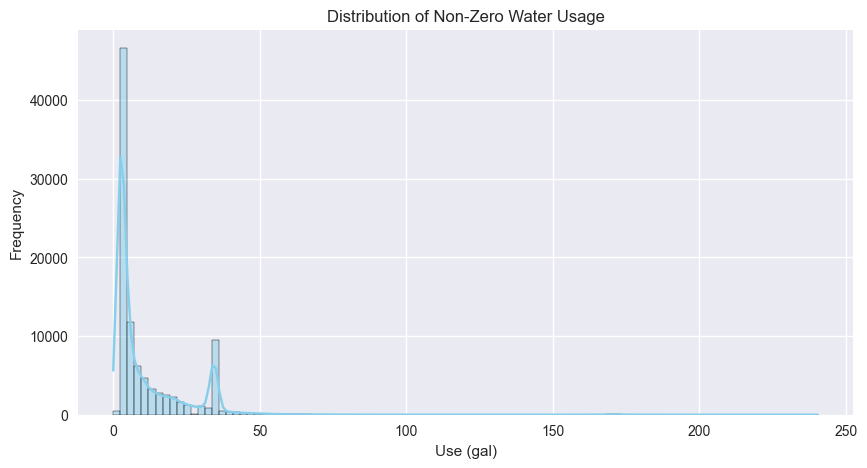

In [569]:
# Filter non-zero values
non_zero_usage = df_processed[df_processed['Use (gal)'] > 0]['Use (gal)']

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(non_zero_usage, bins=100, kde=True, color='skyblue')
plt.title('Distribution of Non-Zero Water Usage')
plt.xlabel('Use (gal)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


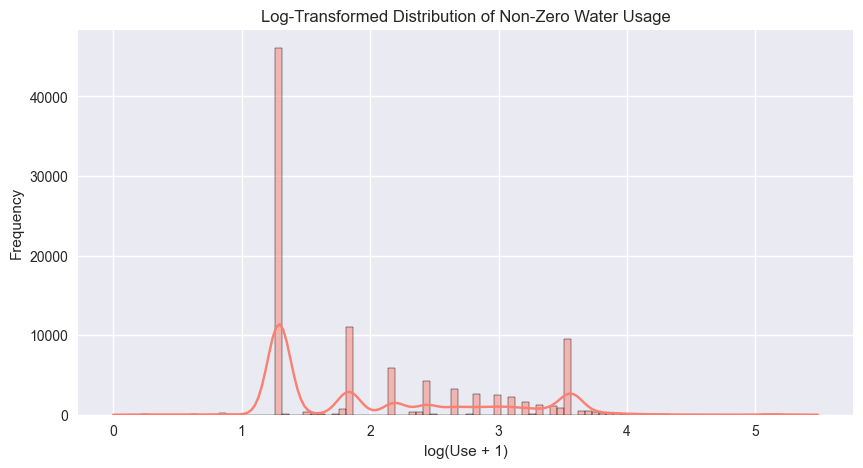

In [570]:
log_usage = np.log1p(non_zero_usage)

plt.figure(figsize=(10, 5))
sns.histplot(log_usage, bins=100, kde=True, color='salmon')
plt.title('Log-Transformed Distribution of Non-Zero Water Usage')
plt.xlabel('log(Use + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


VISUALIZATIONS


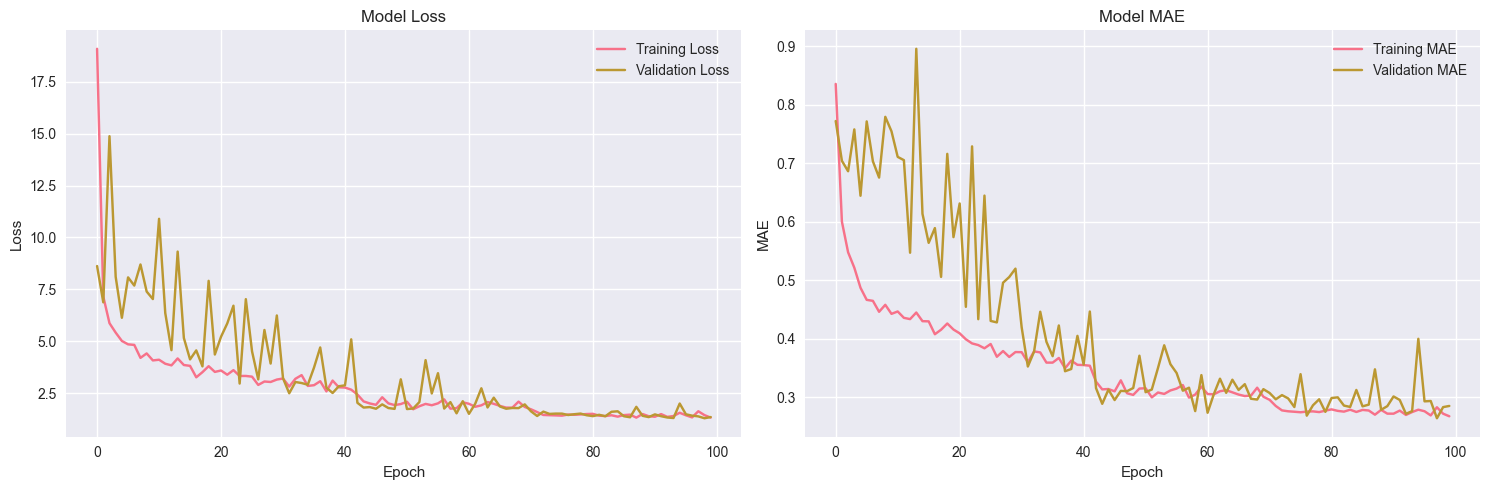

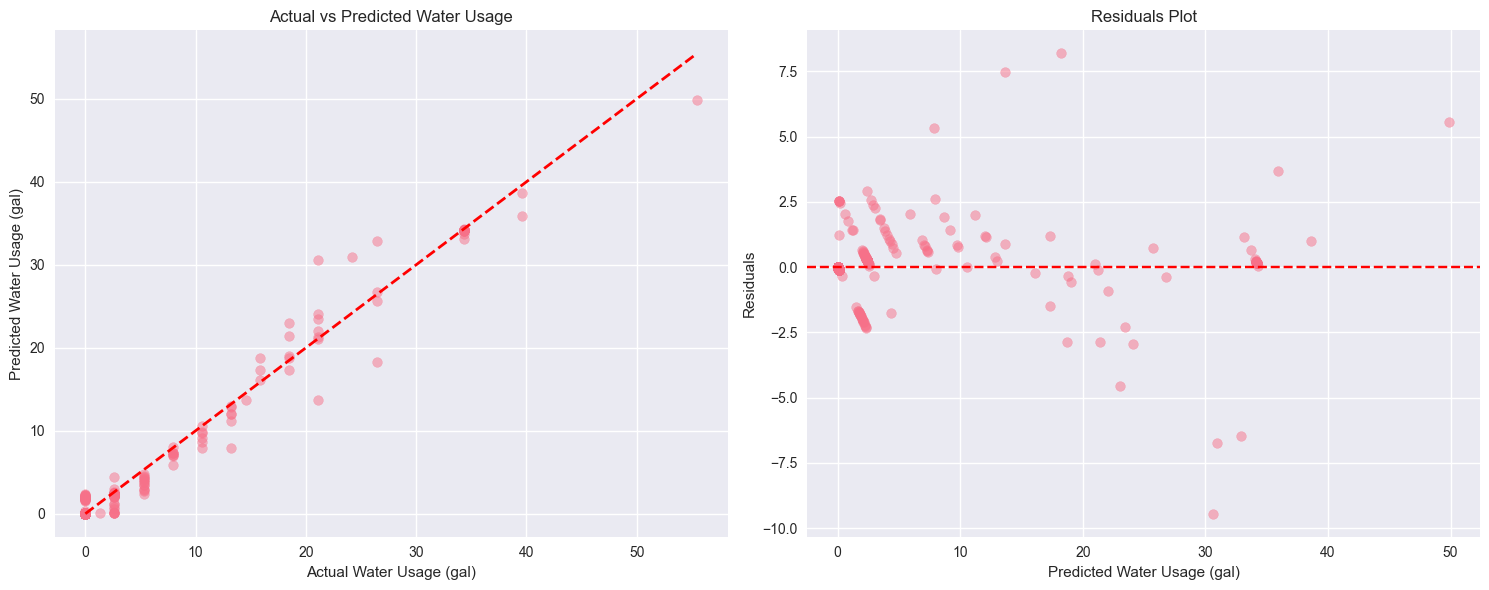


Feature Importance Analysis (Random Forest baseline):

Top 20 Most Important Features:
               feature  importance
14    water_use_ema_3h    0.843274
17   zero_usage_streak    0.084579
15    water_use_ema_5h    0.024846
19         last_3h_sum    0.023615
18       temp_delta_1h    0.015471
1                 Hour    0.001954
2   Accu Reading (gal)    0.001228
4      Signal Strength    0.001008
3     Water Temp (gal)    0.000911
0                 Unit    0.000567
5          Unit Number    0.000451
13               Month    0.000354
12           DayOfWeek    0.000341
7       Unit Size (SM)    0.000280
11      Unit Size (Sf)    0.000279
16         use_lag_24h    0.000244
23            is_night    0.000126
22     is_working_hour    0.000094
25          is_evening    0.000065
24          is_morning    0.000063


Text(0.5, 0, 'Importance')

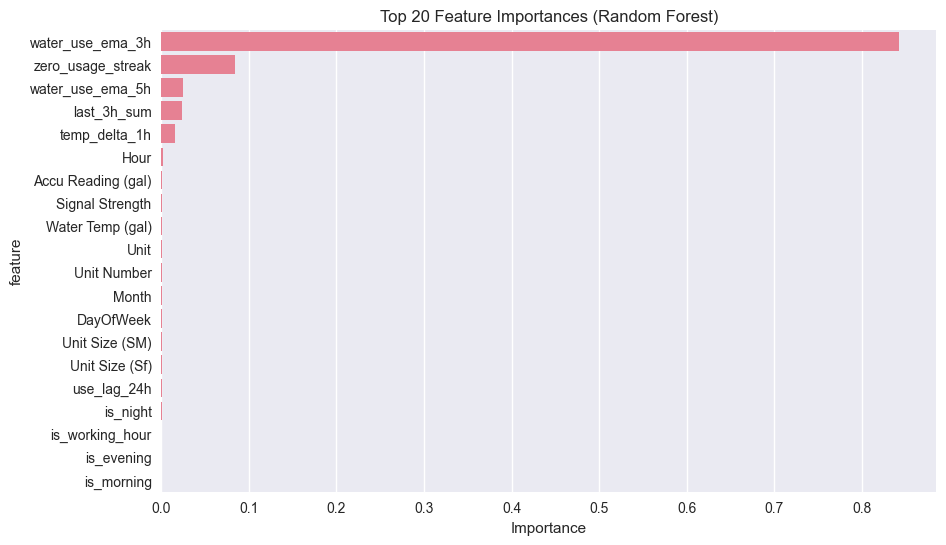

In [564]:
# Visualizations
print("\n" + "="*50)
print("VISUALIZATIONS")
print("="*50)

# Plot training history
plot_training_history()

# Plot predictions
plot_predictions(y_test, y_pred_test)

# Feature importance using Random Forest as baseline
print("\nFeature Importance Analysis (Random Forest baseline):")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_num_train, y_train)

feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')

In [566]:
print(df_processed.columns)

Index(['Date', 'Unit', 'Hour', 'Time Adjusted by Property', 'Use (gal)',
       'Accu Reading (gal)', 'Water Temp (gal)', 'Signal Strength', 'Location',
       'Unit Number', 'Unit Type', 'Status', 'Unit Size (SM)', 'No. Bedrooms',
       'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'DayOfWeek',
       'Month', 'water_use_ema_3h', 'water_use_ema_5h', 'use_lag_24h',
       'zero_usage_streak', 'temp_delta_1h', 'last_3h_sum', 'inactivity_flag',
       'is_weekend', 'is_working_hour', 'is_night', 'is_morning', 'is_evening',
       'Location_encoded', 'Unit Type_encoded'],
      dtype='object')


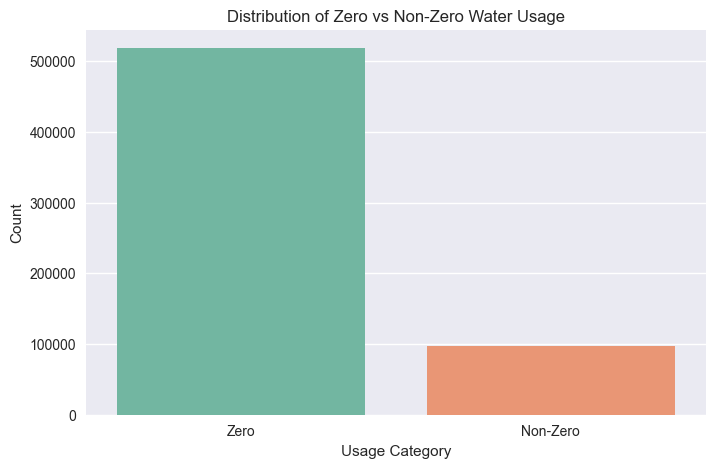

usage_category
Zero        84.184233
Non-Zero    15.815767
Name: proportion, dtype: float64


In [568]:
# Create a binary label for visualization
df_processed['usage_category'] = df_processed['Use (gal)'].apply(lambda x: 'Zero' if x == 0 else 'Non-Zero')

# Countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_processed, x='usage_category', palette='Set2')
plt.title('Distribution of Zero vs Non-Zero Water Usage')
plt.xlabel('Usage Category')
plt.ylabel('Count')
plt.show()

# Print the proportions
print(df_processed['usage_category'].value_counts(normalize=True) * 100)

In [407]:
#synthetic data embeddeding like outliers
#remove all the features related to water usage as its the target value
#nested cross validation
#prev week avg, prev day avg
#make it on day level rather than hour basis
#handle class imbalance
#remove all the vacant

ValueError: could not convert string to float: 'Floor 02'